In [9]:
%pip install pyarrow pandas

   ---------------------------------------- 0.0/25.7 MB ? eta -:--:--
   ------------ --------------------------- 7.9/25.7 MB 37.4 MB/s eta 0:00:01
   -------------------------------- ------- 21.0/25.7 MB 49.1 MB/s eta 0:00:01
   ---------------------------------------  25.4/25.7 MB 46.0 MB/s eta 0:00:01
   ---------------------------------------- 25.7/25.7 MB 36.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install lightgbm


  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error
import lightgbm as lgb
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import os
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")

Current working directory: c:\Users\felic\Downloads\MicronDataChallenge


In [5]:
meas_df      = pd.read_parquet("./train/metrology_data1.parquet")

In [7]:
incom_run_df  = pd.read_parquet("./train/incoming_run_data_1.parquet")

In [8]:
run_df       = pd.read_parquet("./train/run_data_1.parquet")

In [9]:
print(f"Runs: {run_df.shape}, Incoming Runs: {incom_run_df.shape}, Measurements: {meas_df.shape}")

Runs: (2235645, 10), Incoming Runs: (4469164, 9), Measurements: (11025, 9)


In [10]:
run_df.head()

Tool ID Run Start Time        Run End Time  \
0  8060e8e1-504a-5138-a9f0-e2770bd61ba1     2024-01-01 2024-01-01 00:12:35   
1  8060e8e1-504a-5138-a9f0-e2770bd61ba1     2024-01-01 2024-01-01 00:12:35   
2  8060e8e1-504a-5138-a9f0-e2770bd61ba1     2024-01-01 2024-01-01 00:12:35   
3  8060e8e1-504a-5138-a9f0-e2770bd61ba1     2024-01-01 2024-01-01 00:12:35   
4  8060e8e1-504a-5138-a9f0-e2770bd61ba1     2024-01-01 2024-01-01 00:12:35   

                                 Run ID                          Process Step  \
0  6515456b-05d4-5e6d-b42a-7652a8d671a4  22c8716b-1c14-525a-8c0a-0473ec7aa99e   
1  6515456b-05d4-5e6d-b42a-7652a8d671a4  22c8716b-1c14-525a-8c0a-0473ec7aa99e   
2  6515456b-05d4-5e6d-b42a-7652a8d671a4  22c8716b-1c14-525a-8c0a-0473ec7aa99e   
3  6515456b-05d4-5e6d-b42a-7652a8d671a4  22c8716b-1c14-525a-8c0a-0473ec7aa99e   
4  6515456b-05d4-5e6d-b42a-7652a8d671a4  22c8716b-1c14-525a-8c0a-0473ec7aa99e   

   Consumable Life Step ID                    Time Stamp Sensor Name  \
0         370.7229  Step_0 2024-01-01 00:00:00.000000000    Sensor_A   
1         370.7229  Step_0 2024-01-01 00:00:01.000000002    Sensor_A   
2         370.7229  Step_0 2024-01-01 00:00:01.999999997    Sensor_A   
3         370.7229  Step_1 2024-01-01 00:00:03.000000000    Sensor_A   
4         370.7229  Step_1 2024-01-01 00:00:04.000000002    Sensor_A   

   Sensor Value  
0     -0.061105  
1     -0.040894  
2      0.005357  
3     -0.029941  
4     -0.098098

In [11]:
print(run_df.columns.tolist())

['Tool ID', 'Run Start Time', 'Run End Time', 'Run ID', 'Process Step', 'Consumable Life', 'Step ID', 'Time Stamp', 'Sensor Name', 'Sensor Value']


In [17]:
print(run_df.describe())

                      Run Start Time                   Run End Time  \
count                        2235645                        2235645   
mean   2024-01-02 13:38:00.750554624  2024-01-02 13:50:35.750555648   
min              2024-01-01 00:00:00            2024-01-01 00:12:35   
25%              2024-01-01 19:05:10            2024-01-01 19:17:45   
50%              2024-01-02 13:17:35            2024-01-02 13:30:10   
75%              2024-01-03 08:40:20            2024-01-03 08:52:55   
max              2024-01-04 04:38:15            2024-01-04 04:50:50   
std                              NaN                            NaN   

       Consumable Life                     Time Stamp  Sensor Value  
count     2.235645e+06                        2235645  2.235645e+06  
mean      2.567603e+02  2024-01-02 13:43:32.848366592  8.635466e+02  
min       2.960730e+01            2024-01-01 00:00:00 -5.701456e+06  
25%       1.507145e+02            2024-01-01 19:06:07  6.827777e+00  
50%       

In [34]:
print('Number of Run ID:', run_df["Run ID"].nunique())
print('Number of Process Steps:', run_df["Process Step"].nunique())
print('Number of Step ID:', run_df["Step ID"].nunique())
print('Number of Sensor Name:', run_df["Sensor Name"].nunique())

Number of Run ID: 225
Number of Process Steps: 1
Number of Step ID: 13
Number of Sensor Name: 15


In [38]:
# Number of random run IDs you want to select
num_random_ids = 1

# Select random run IDs
random_run_ids = run_df['Run ID'].sample(n=num_random_ids, random_state=42).tolist()

print(random_run_ids)

# Filter the DataFrame
filtered_df = run_df[run_df['Run ID'].isin(random_run_ids)]

['abfd3d46-d932-5836-8a3a-b290ad6f60d1']


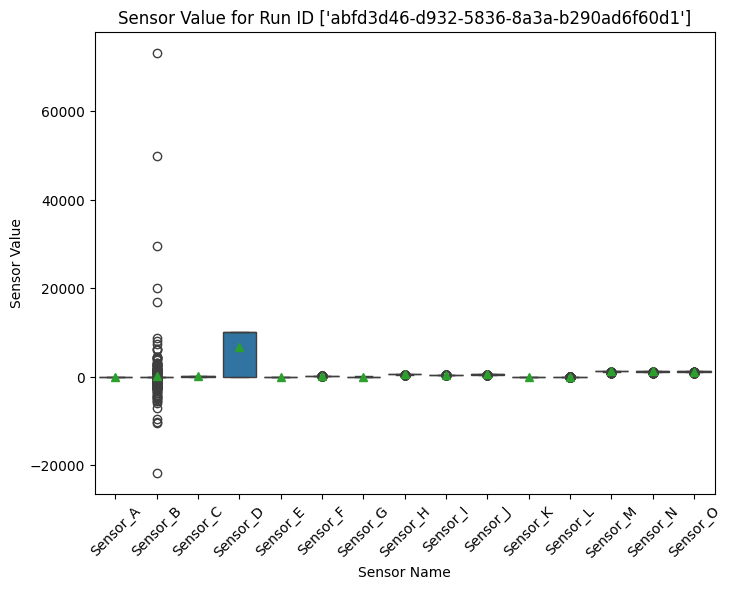

Sensor Name
Sensor_A       0.004151
Sensor_B     194.904404
Sensor_C     113.713455
Sensor_D    6743.330566
Sensor_E       6.184203
Sensor_F     135.135056
Sensor_G      55.128780
Sensor_H     569.863586
Sensor_I     497.543762
Sensor_J     546.445312
Sensor_K      14.546702
Sensor_L       5.243138
Sensor_M    1257.567993
Sensor_N    1231.142456
Sensor_O    1210.735474
Name: Sensor Value, dtype: float32


In [41]:
# Plot the graph
plt.figure(figsize=(8, 6))  # Adjust figure size
sns.boxplot(x='Sensor Name', y='Sensor Value', data=filtered_df, showmeans=True)
plt.xticks(rotation=45)
plt.title(f'Sensor Value for Run ID {random_run_ids}')

# Show the plot
plt.show()

grouped_df = filtered_df.groupby(["Sensor Name"])["Sensor Value"].mean()
print(grouped_df)

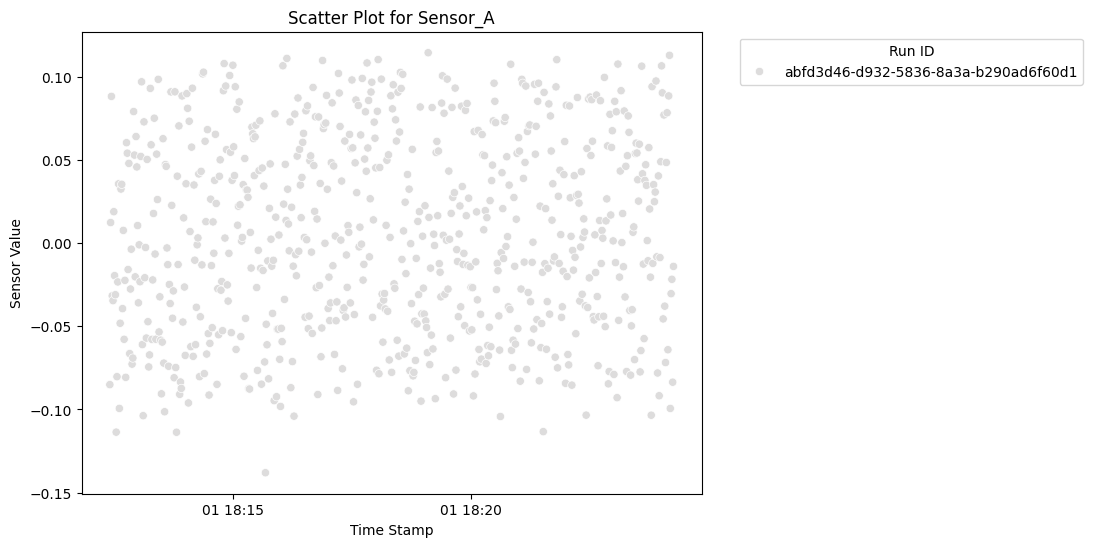

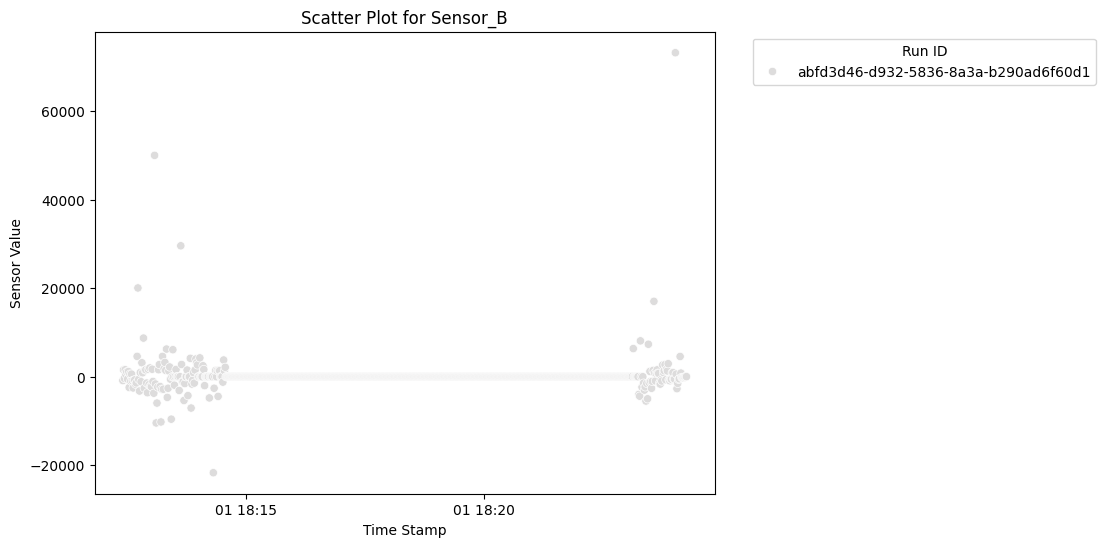

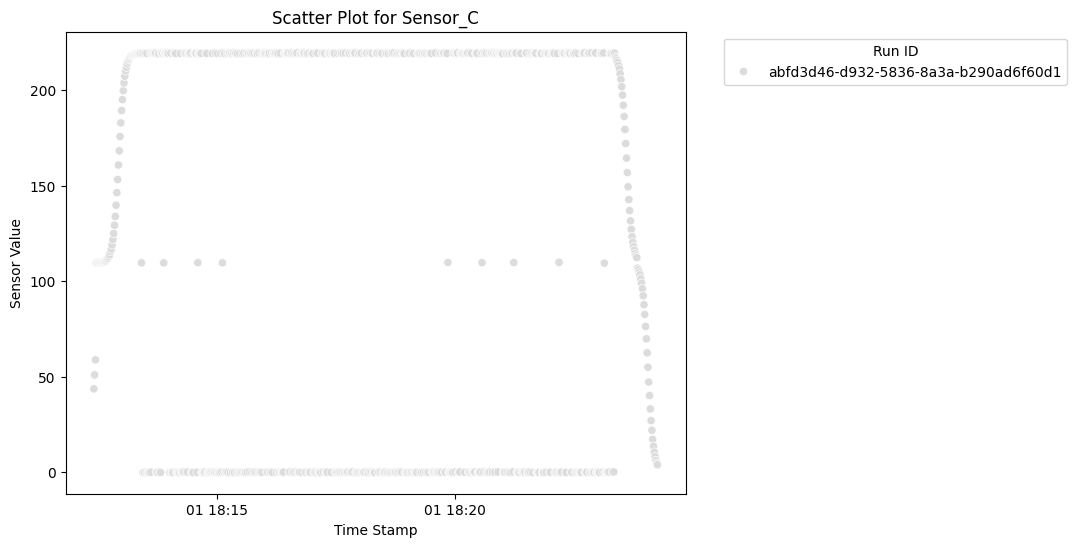

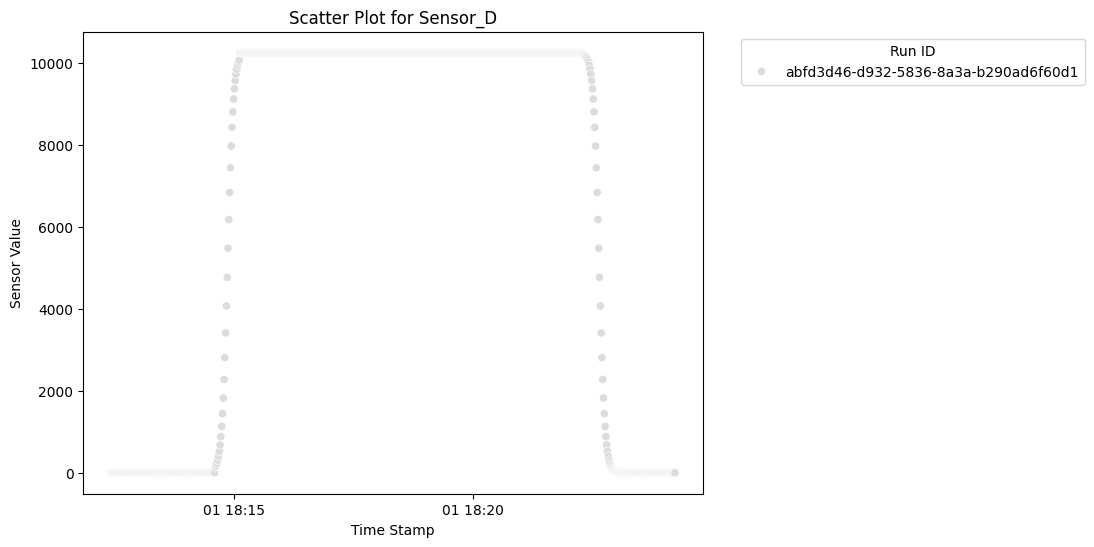

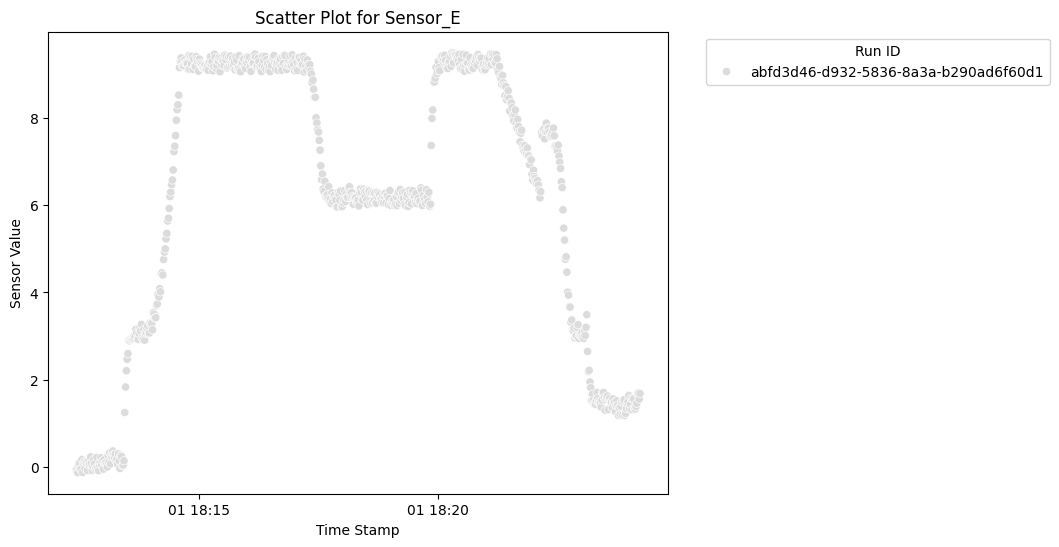

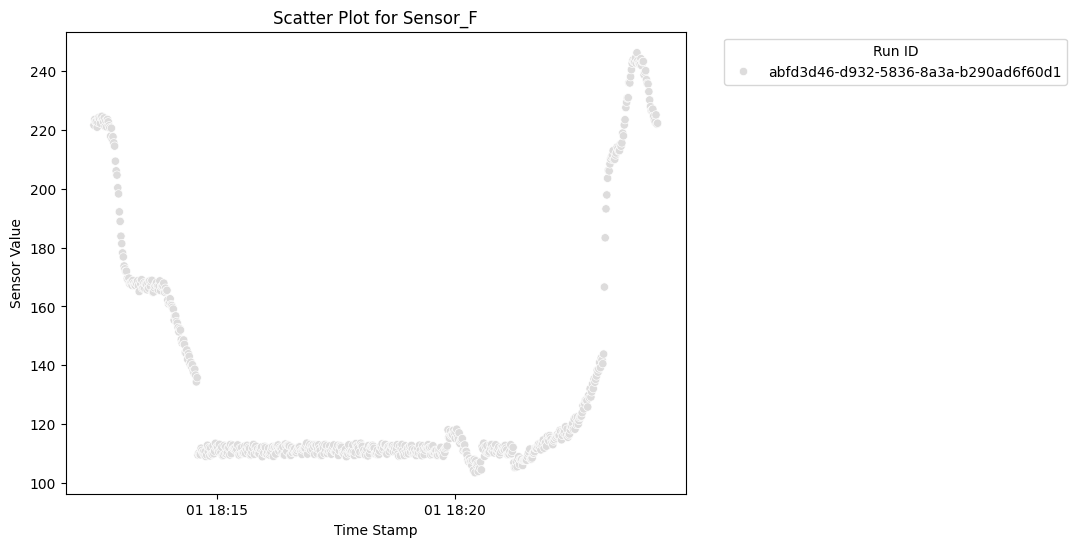

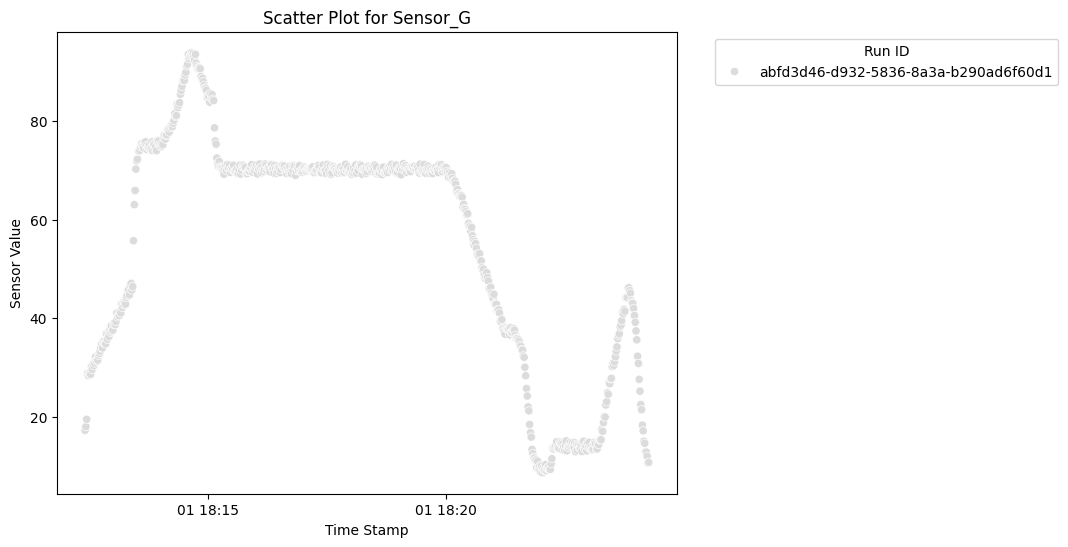

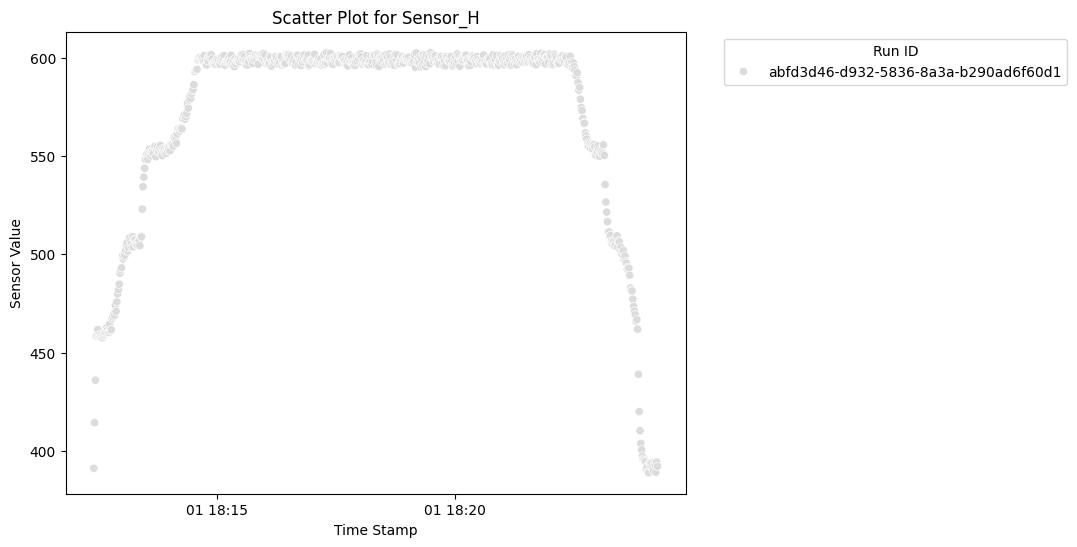

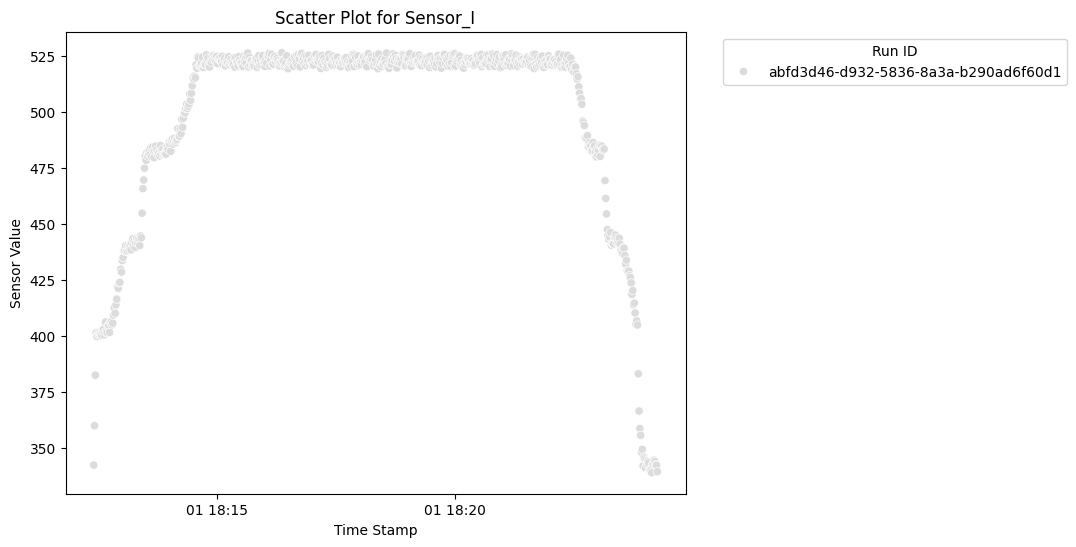

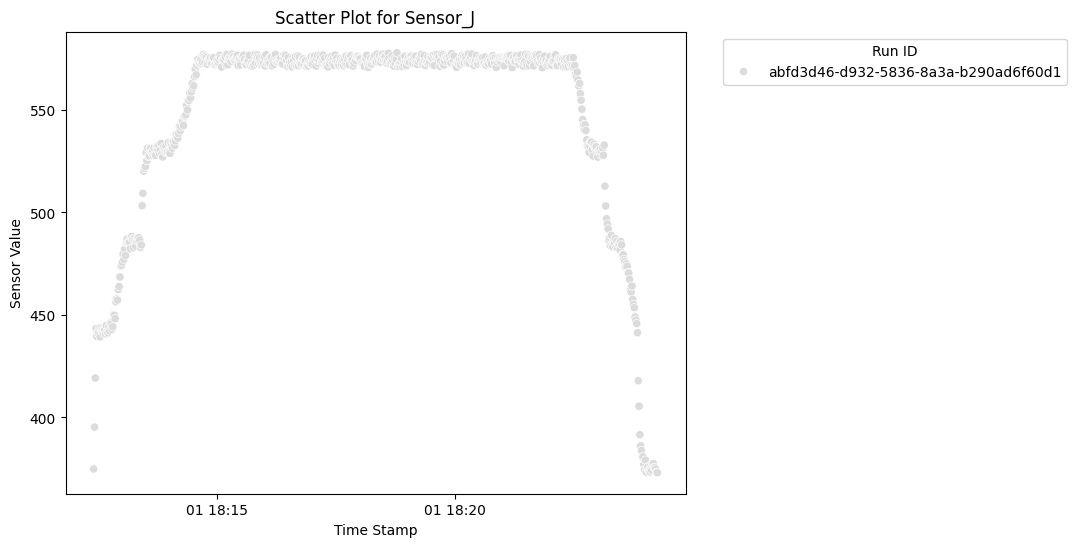

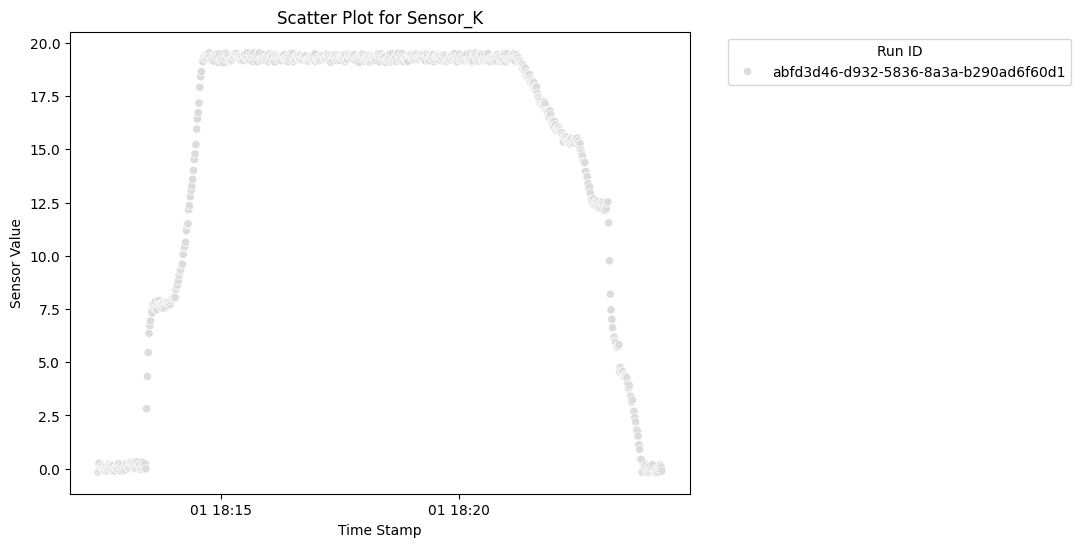

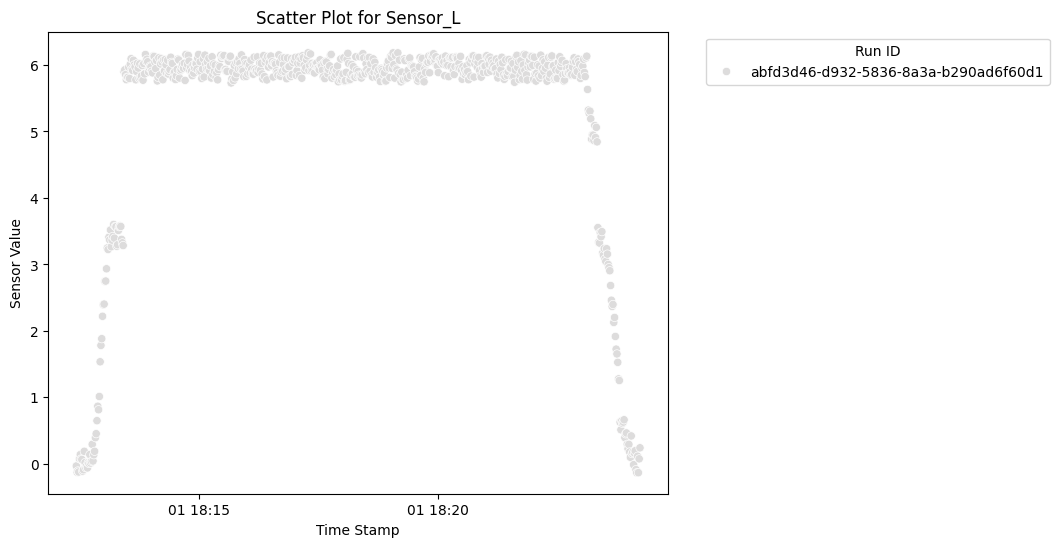

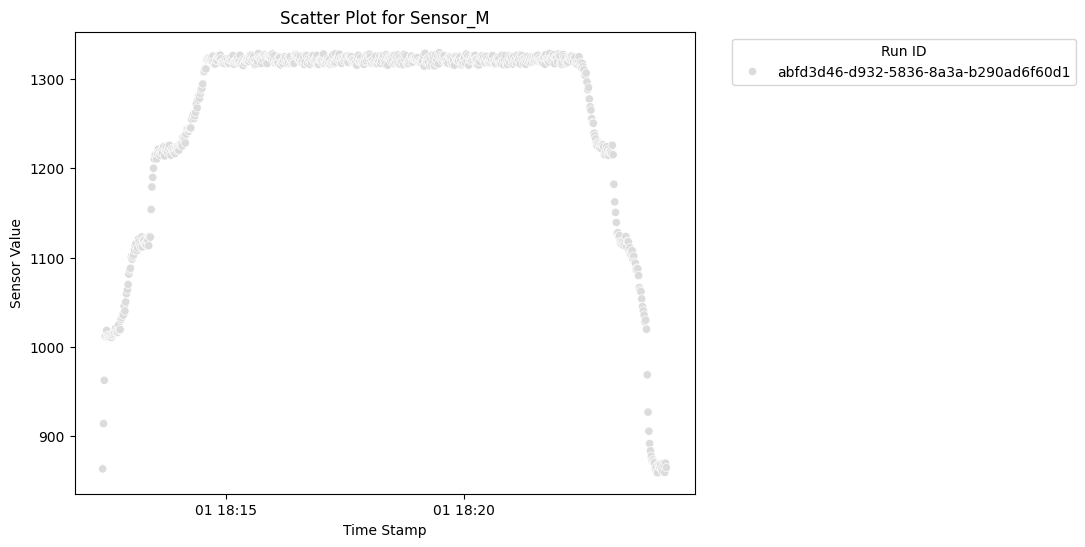

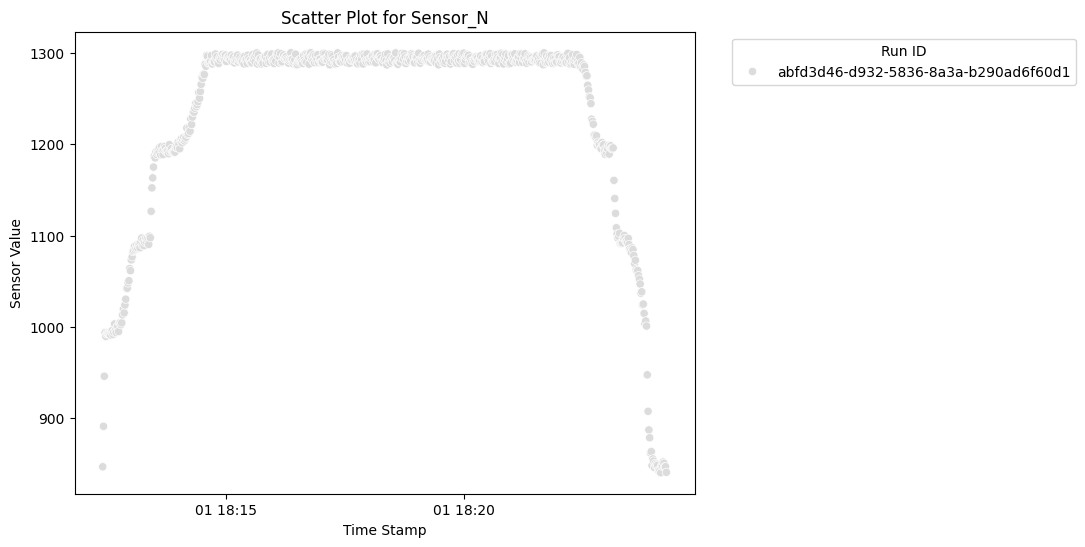

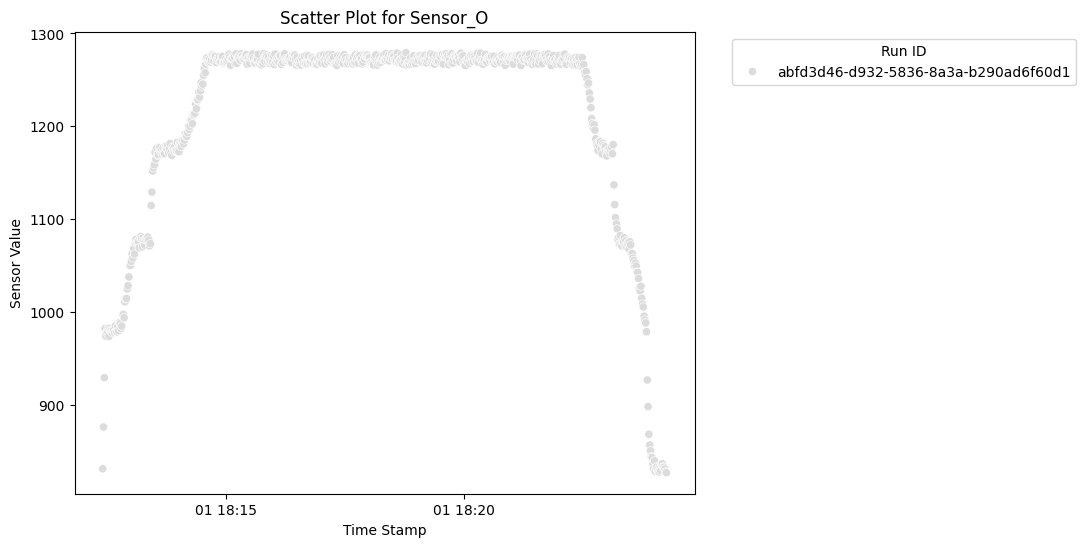

In [42]:
for sensor in filtered_df['Sensor Name'].unique():
    subset_df = filtered_df[filtered_df['Sensor Name'] == sensor]  # Filter data for each Run ID
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='Time Stamp', y='Sensor Value', hue='Run ID', palette='coolwarm', data=subset_df)
    plt.legend(title="Run ID", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f"Scatter Plot for {sensor}")
    plt.show()


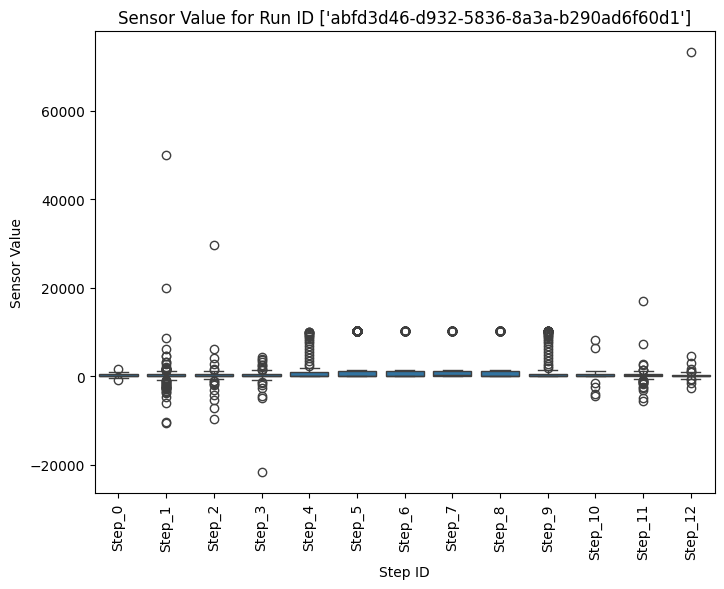

Step ID
Step_0      283.238373
Step_1      380.851074
Step_10     352.534515
Step_11     357.721069
Step_12     467.859894
Step_2      386.227173
Step_3      368.792358
Step_4      723.499512
Step_5     1076.665161
Step_6     1076.258667
Step_7     1076.975220
Step_8     1073.533936
Step_9      723.946106
Name: Sensor Value, dtype: float32


In [48]:
# Plot the graph
plt.figure(figsize=(8, 6))  # Adjust figure size
sns.boxplot(x='Step ID', y='Sensor Value', data=filtered_df)
plt.xticks(rotation=90)
plt.title(f'Sensor Value for Run ID {random_run_ids}')

# Show the plot
plt.show()

grouped_df = filtered_df.groupby(["Step ID"])["Sensor Value"].mean()
print(grouped_df)

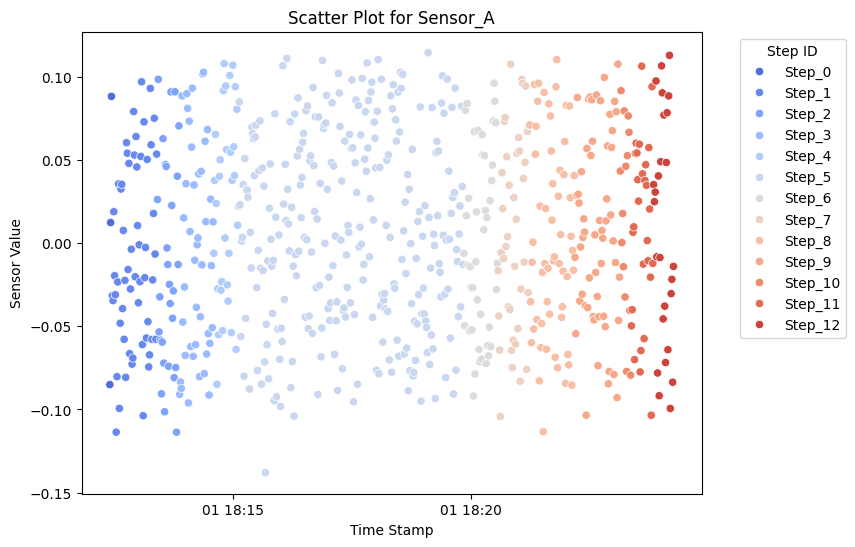

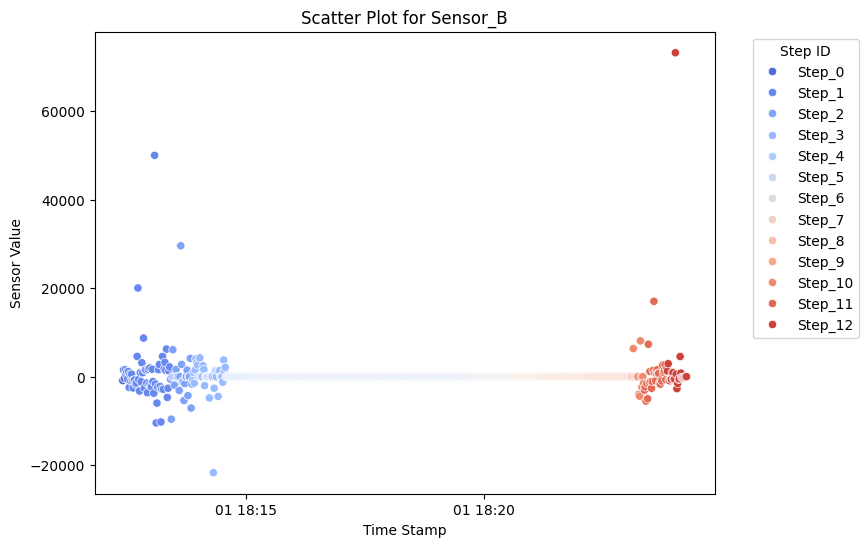

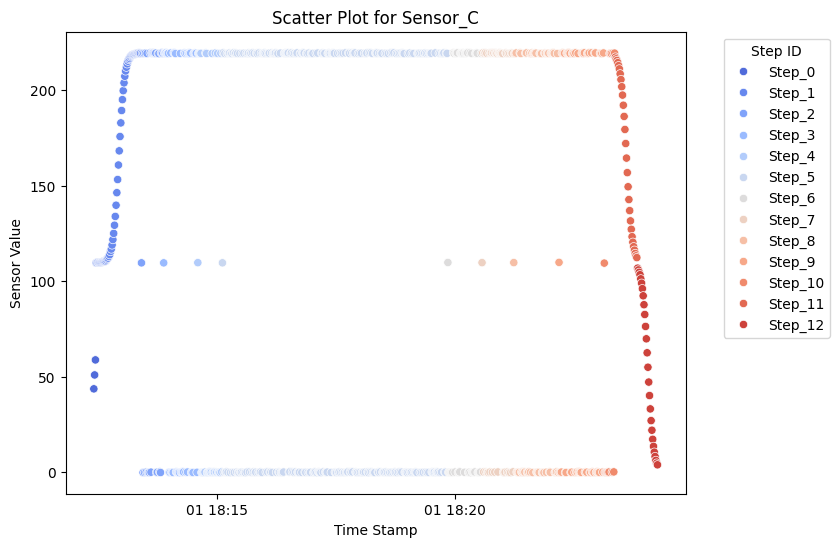

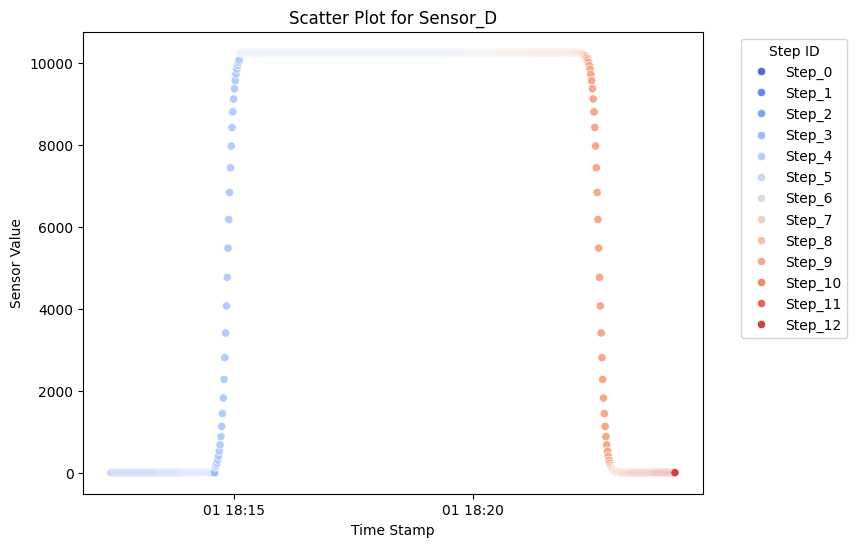

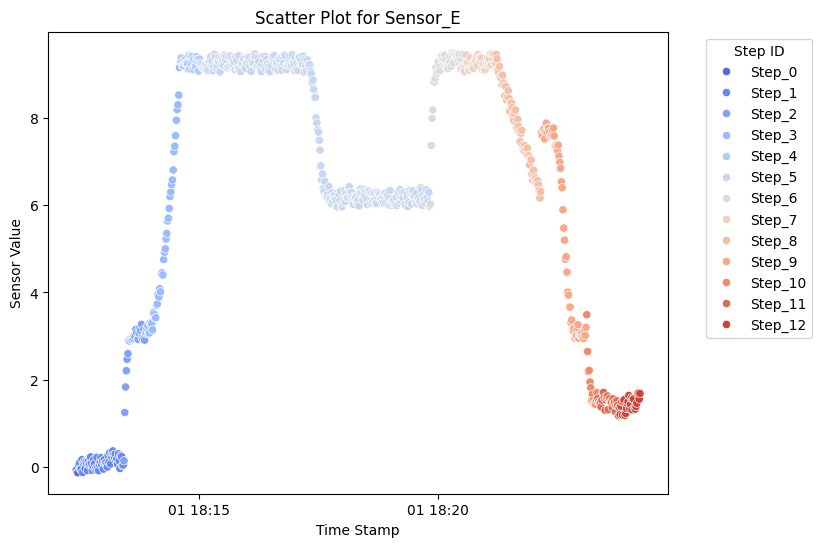

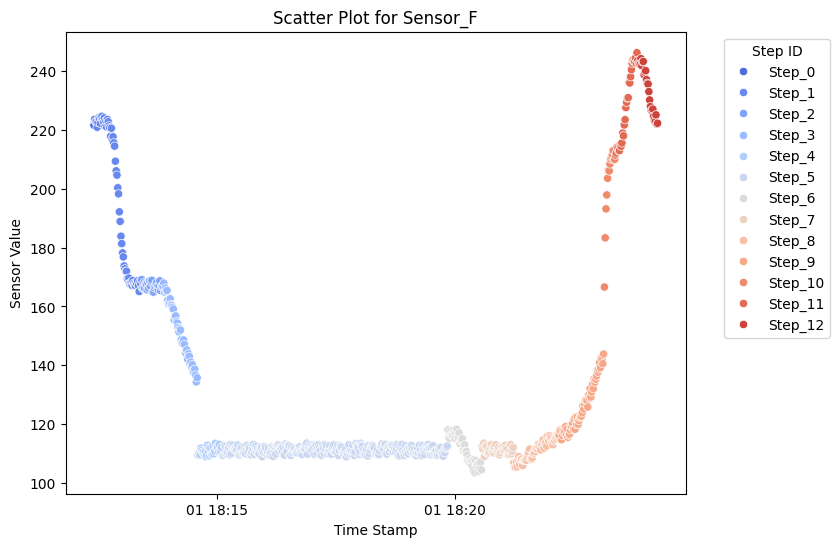

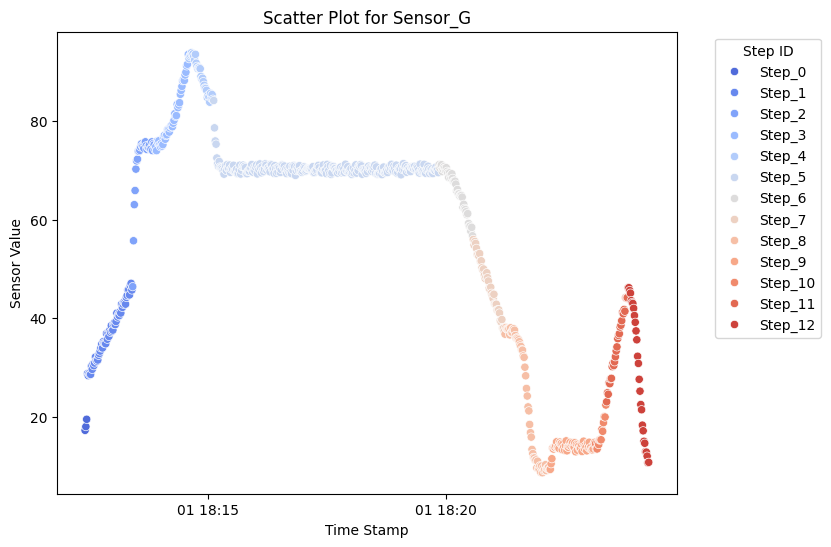

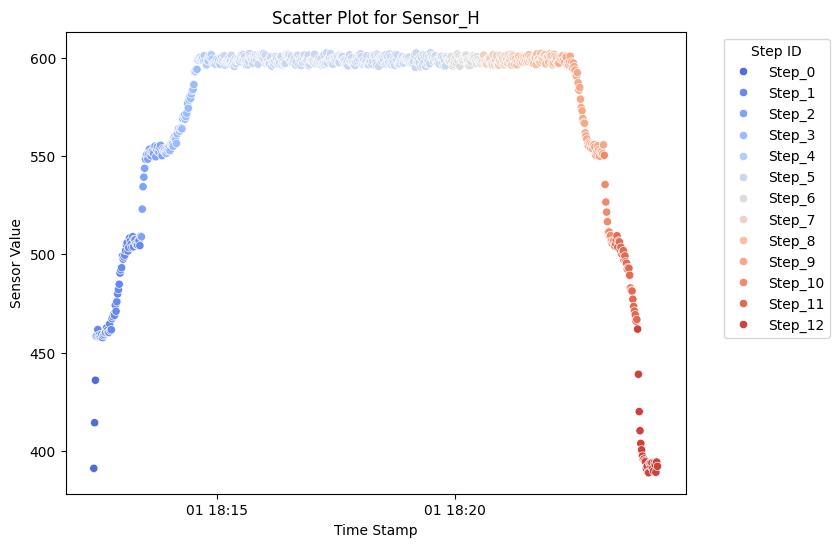

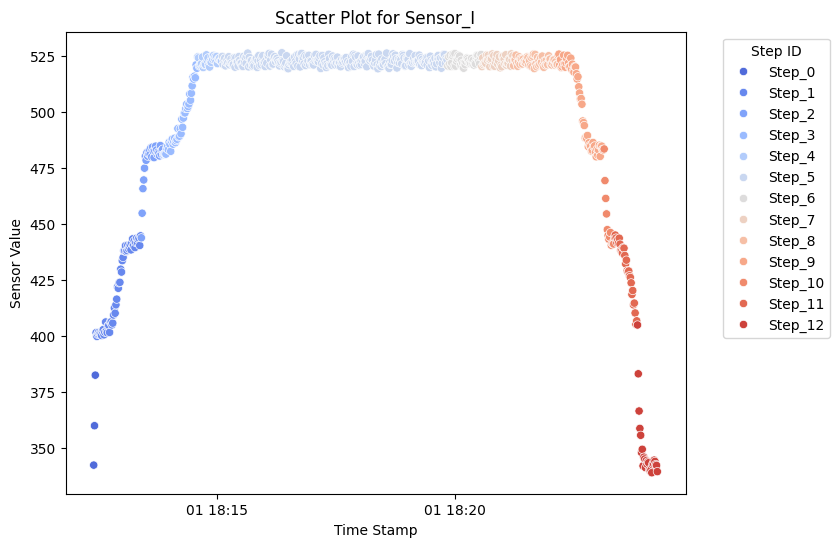

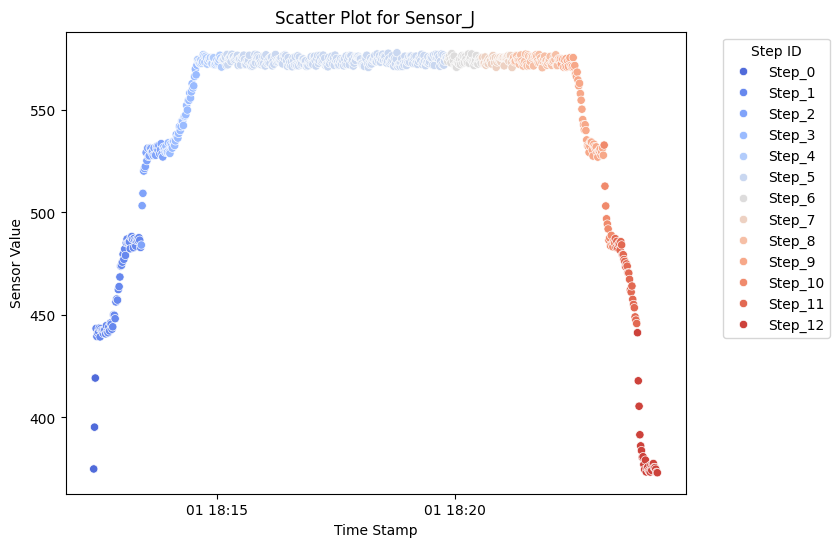

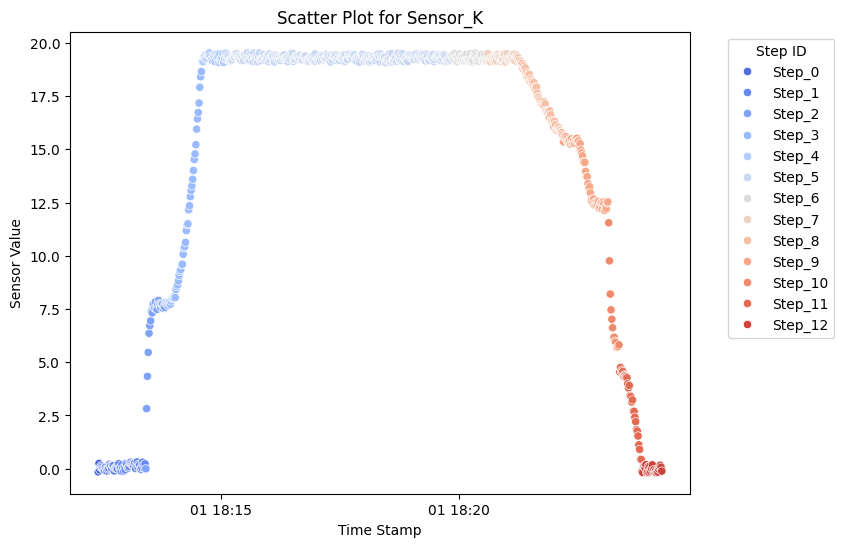

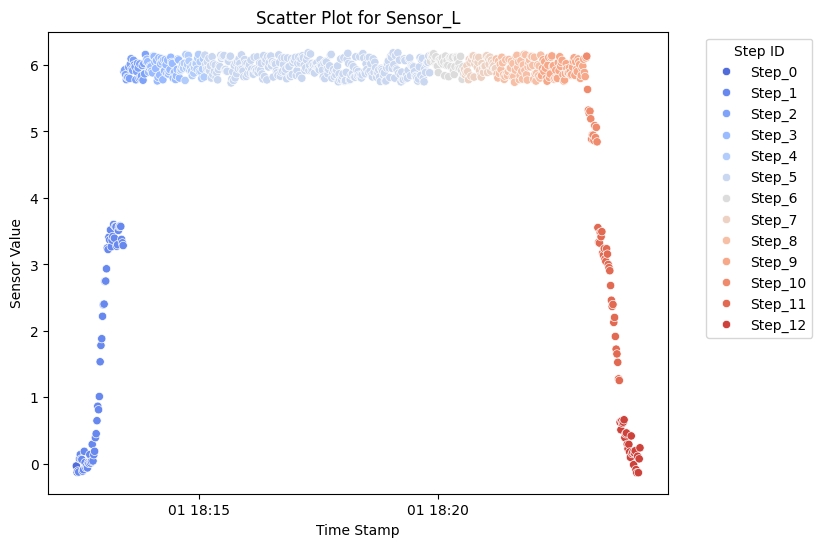

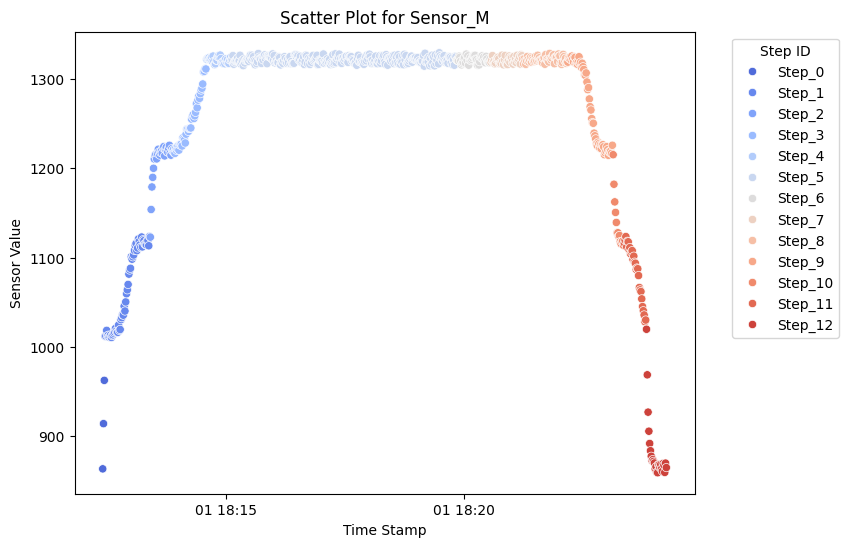

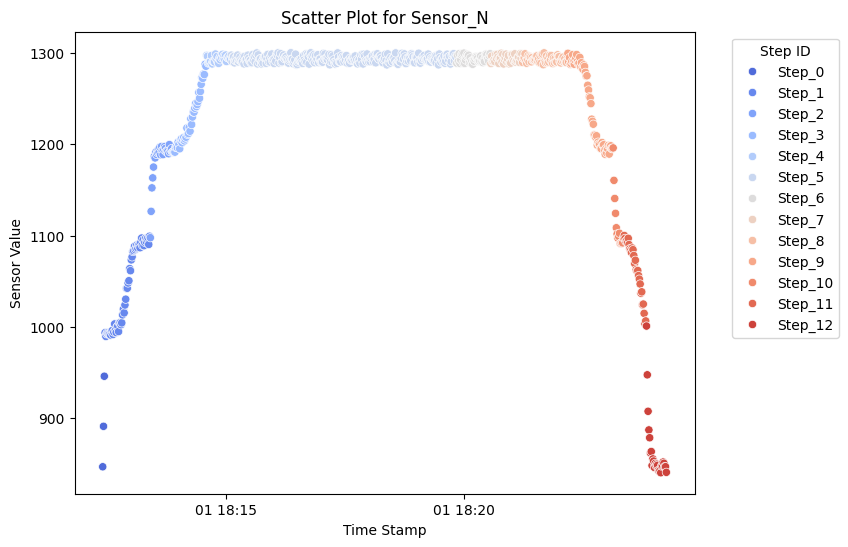

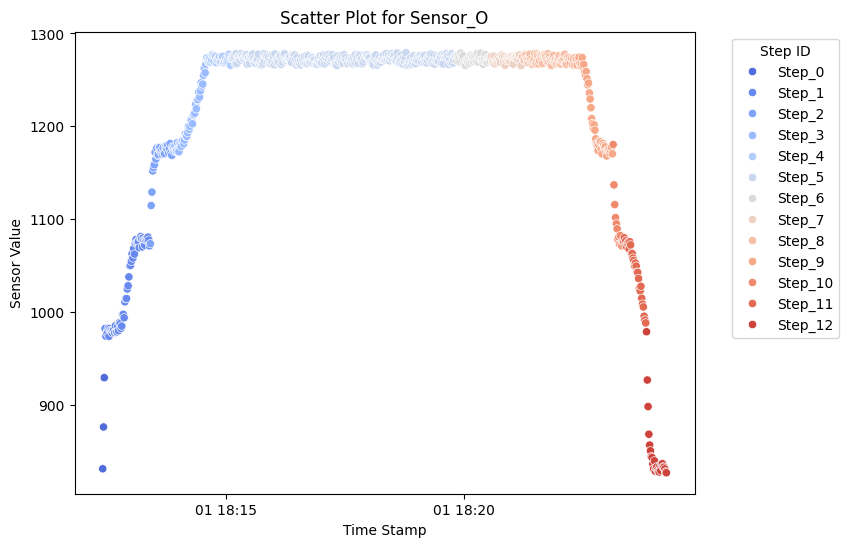

In [49]:
for sensor in filtered_df['Sensor Name'].unique():
    subset_df = filtered_df[filtered_df['Sensor Name'] == sensor]  # Filter data for each Run ID
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='Time Stamp', y='Sensor Value', hue='Step ID', palette='coolwarm', data=subset_df)
    plt.legend(title="Step ID", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f"Scatter Plot for {sensor}")
    plt.show()


In [50]:
# # 1. Filter by IQR
# # Compute IQR for each Sensor Name group
# def filter_iqr(group):
#     Q1 = group['Sensor Value'].quantile(0.25)
#     Q3 = group['Sensor Value'].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     return group[(group['Sensor Value'] >= lower_bound) & (group['Sensor Value'] <= upper_bound)]

# # Apply IQR filtering per sensor group
# new_df = filtered_df.groupby('Sensor Name', group_keys=False).apply(filter_iqr)

# print('before removing outliers:', len(filtered_df))
# print('after removing outliers:',len(new_df))
# print('outliers:', len(filtered_df)-len(new_df))


# 2. Filter by Z-score
# Compute Z-score per sensor group
filtered_df['Z-score'] = filtered_df.groupby('Sensor Name')['Sensor Value'].transform(lambda x: (x - x.mean()) / x.std())

# Filter outliers (absolute Z-score above threshold, e.g., 3)
new_df = filtered_df[abs(filtered_df['Z-score']) < 3]

print('before removing outliers:', len(filtered_df))
print('after removing outliers:',len(new_df))
print('outliers:', len(filtered_df)-len(new_df))

before removing outliers: 10665
after removing outliers: 10487
outliers: 178


C:\Users\felic\AppData\Local\Temp\ipykernel_2820\1755972448.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Z-score'] = filtered_df.groupby('Sensor Name')['Sensor Value'].transform(lambda x: (x - x.mean()) / x.std())


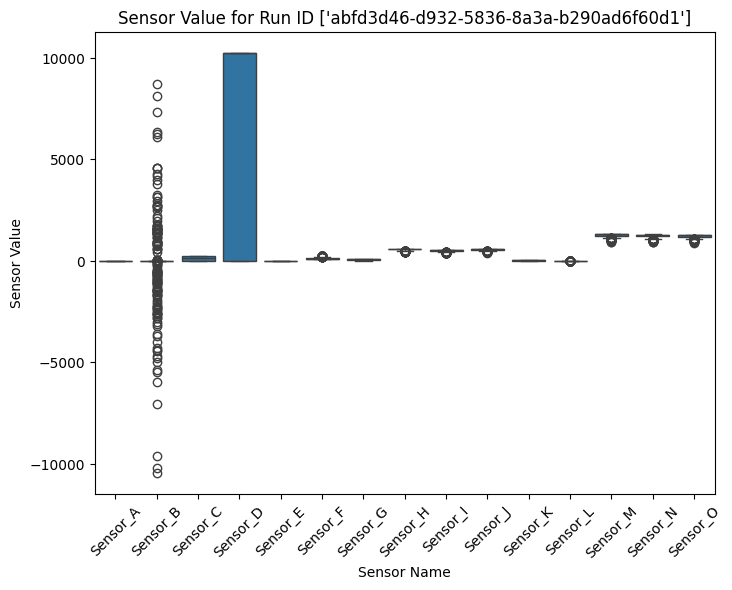

In [51]:
# Plot the graph
plt.figure(figsize=(8, 6))  # Adjust figure size
sns.boxplot(x='Sensor Name', y='Sensor Value', data=new_df)
plt.xticks(rotation=45)
plt.title(f'Sensor Value for Run ID {random_run_ids}')

# Show the plot
plt.show()

In [32]:
# #filter by Step ID
# #comment out if too long
# for step in new_df['Step ID'].unique():
#     plt.figure(figsize=(8, 6))
#     sns.boxplot(x='Sensor Name', y='Sensor Value', data=new_df[new_df['Step ID'] == step])
#     plt.xticks(rotation=45)
#     plt.title(f'Sensor Value for {step} (Run ID {random_run_ids})')
#     plt.show()

In [45]:
# for step in new_df['Process Step'].unique():
#     plt.figure(figsize=(8, 6))
#     sns.boxplot(x='Sensor Name', y='Sensor Value', data=new_df[new_df['Process Step'] == step])
#     plt.xticks(rotation=45)
#     plt.title(f'Sensor Value for {step} (Run ID {random_run_ids})')
#     plt.show()

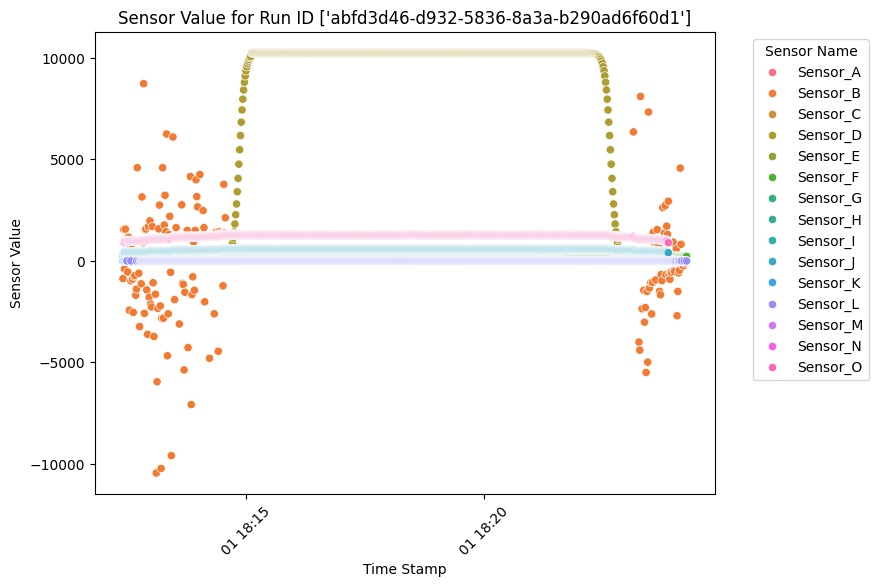

In [52]:
# Plot the graph with categorization
plt.figure(figsize=(8, 6))  # Adjust figure size
sns.scatterplot(x='Time Stamp', y='Sensor Value', hue='Sensor Name', data=new_df)

plt.title(f'Sensor Value for Run ID {random_run_ids}')
plt.legend(title="Sensor Name", bbox_to_anchor=(1.05, 1), loc='upper left')  # Ensure legend shows sensor categories
plt.xticks(rotation=45)  # Rotate timestamps for readability

# Show the plot
plt.show()


In [53]:
print('Number of Run ID:', incom_run_df["Run ID"].nunique())
print('Number of Process Steps:', incom_run_df["Process Step"].nunique())
print('Number of Step ID:', incom_run_df["Step ID"].nunique())
print('Number of Sensor Name:', incom_run_df["Sensor Name"].nunique())

Number of Run ID: 225
Number of Process Steps: 1
Number of Step ID: 8
Number of Sensor Name: 41


In [54]:
# Use Run ID from run_df

print(random_run_ids)
# Filter the DataFrame
filtered_incom_df = incom_run_df[incom_run_df['Run ID'].isin(random_run_ids)]

['abfd3d46-d932-5836-8a3a-b290ad6f60d1']


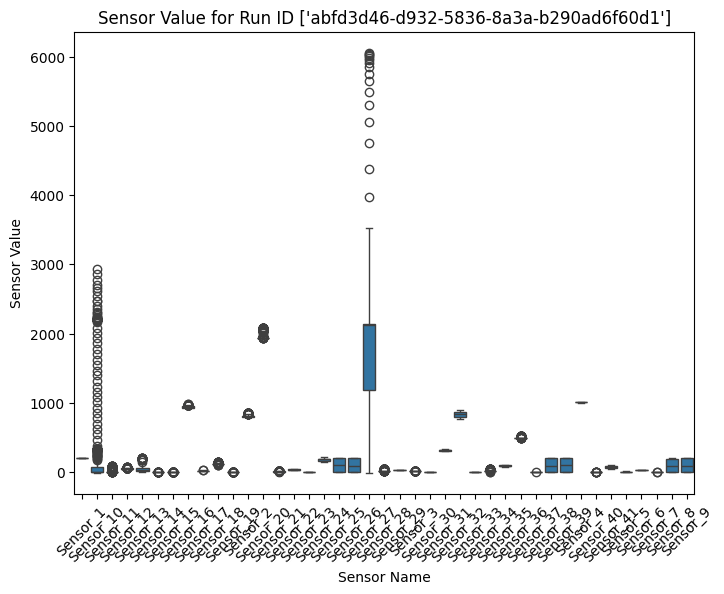

Sensor Name
Sensor_1      205.261398
Sensor_10     310.245178
Sensor_11       5.344971
Sensor_12      53.010948
Sensor_13      48.460068
Sensor_14       0.614861
Sensor_15       5.198719
Sensor_16     942.630615
Sensor_17      18.504023
Sensor_18     121.120934
Sensor_19       0.142302
Sensor_2      812.619385
Sensor_20    1955.001587
Sensor_21       9.133909
Sensor_22      35.796360
Sensor_23       3.472861
Sensor_24     181.620087
Sensor_25      98.763062
Sensor_26      94.742973
Sensor_27    1801.894897
Sensor_28      14.853861
Sensor_29      26.856684
Sensor_3       19.598503
Sensor_30       1.105052
Sensor_31     316.833557
Sensor_32     832.434753
Sensor_33       2.650841
Sensor_34      18.279402
Sensor_35      96.281166
Sensor_36     496.249786
Sensor_37       0.026867
Sensor_38      94.485641
Sensor_39      96.130707
Sensor_4     1006.928589
Sensor_40       5.132308
Sensor_41      72.269501
Sensor_5        5.625201
Sensor_6       23.789618
Sensor_7        3.299252
Sensor_8     

In [56]:
# Plot the graph
plt.figure(figsize=(8, 6))  # Adjust figure size
sns.boxplot(x='Sensor Name', y='Sensor Value', data=filtered_incom_df)
plt.xticks(rotation=45)
plt.title(f'Sensor Value for Run ID {random_run_ids}')

# Show the plot
plt.show()

grouped_df = filtered_incom_df.groupby(["Sensor Name"])["Sensor Value"].mean()
print(grouped_df)

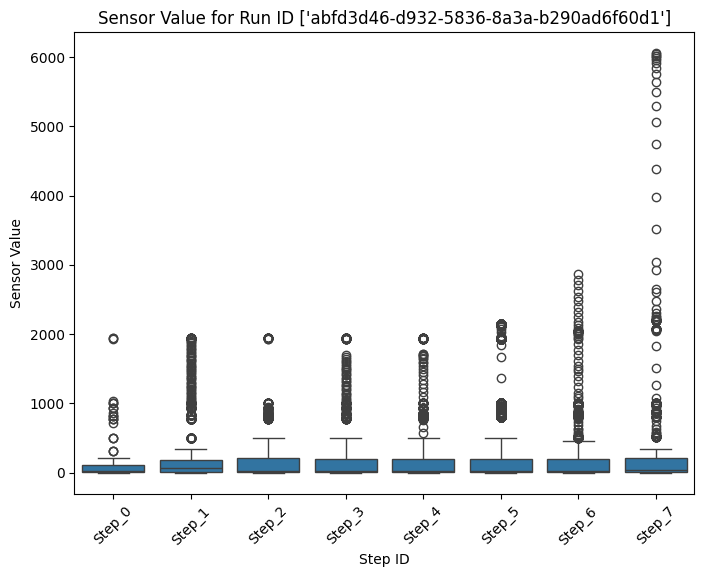

Step ID
Step_0    200.208054
Step_1    235.729965
Step_2    216.960464
Step_3    222.857407
Step_4    220.917847
Step_5    244.187576
Step_6    239.299500
Step_7    330.719696
Name: Sensor Value, dtype: float32


In [57]:
# Plot the graph
plt.figure(figsize=(8, 6))  # Adjust figure size
sns.boxplot(x='Step ID', y='Sensor Value', data=filtered_incom_df)
plt.xticks(rotation=45)
plt.title(f'Sensor Value for Run ID {random_run_ids}')

# Show the plot
plt.show()

grouped_df = filtered_incom_df.groupby(["Step ID"])["Sensor Value"].mean()
print(grouped_df)

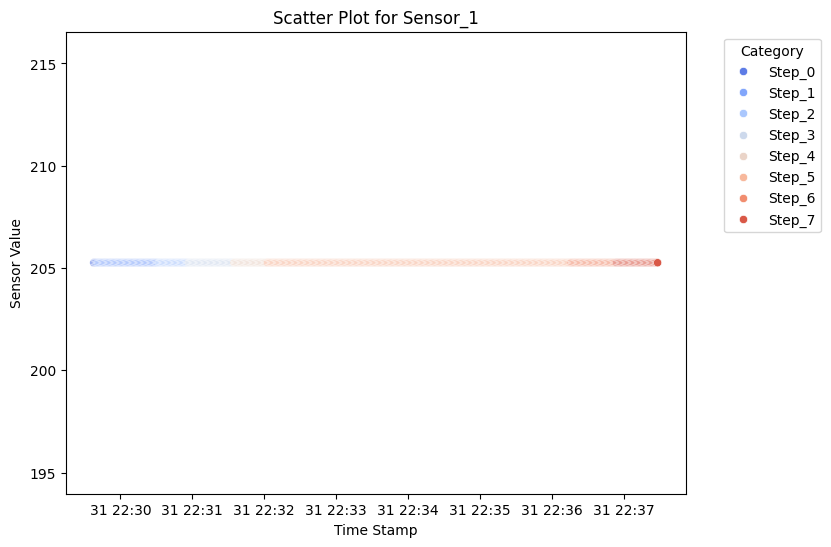

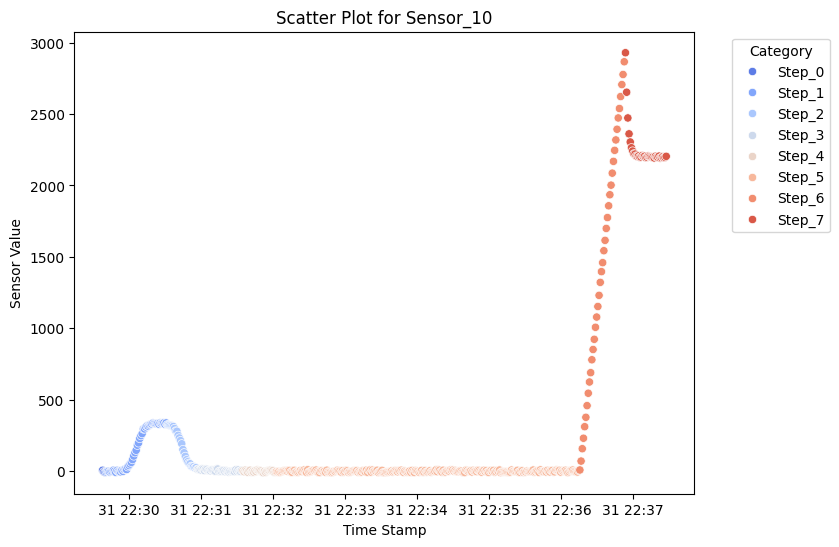

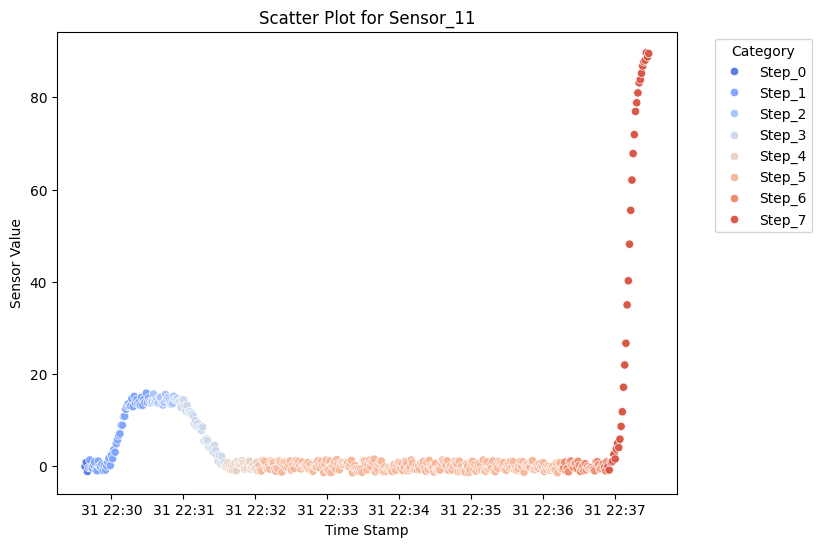

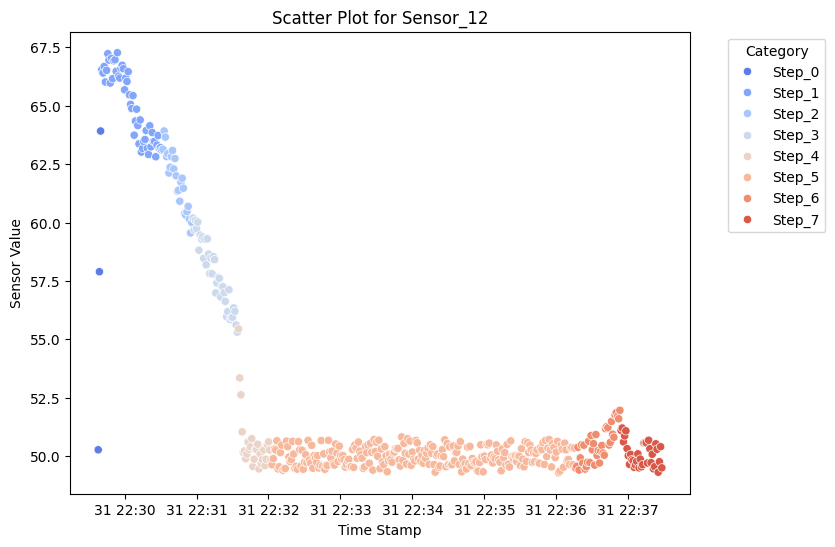

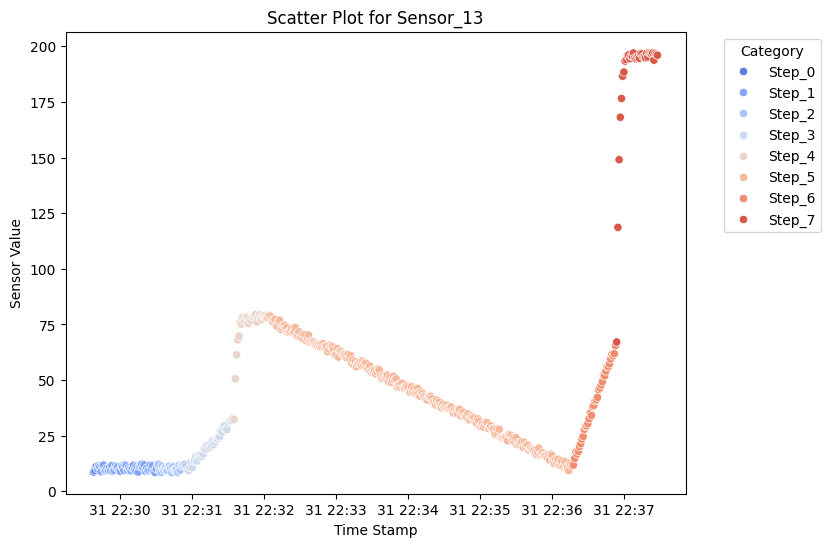

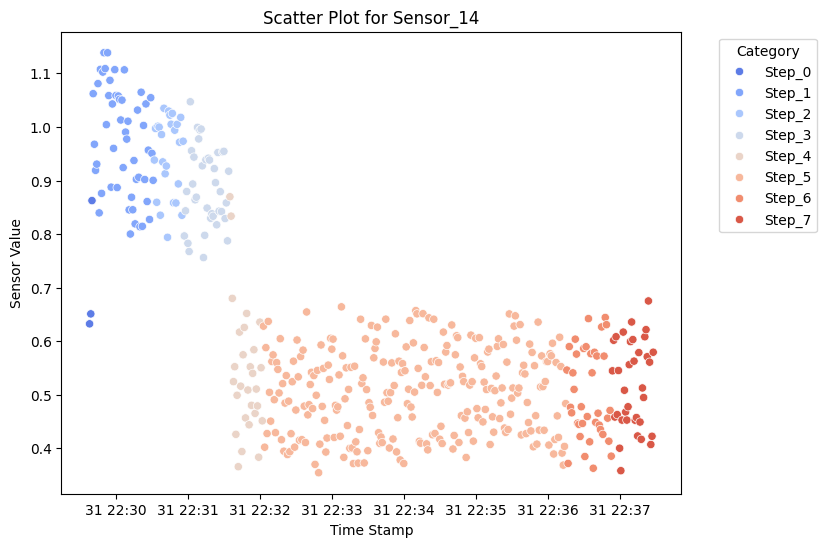

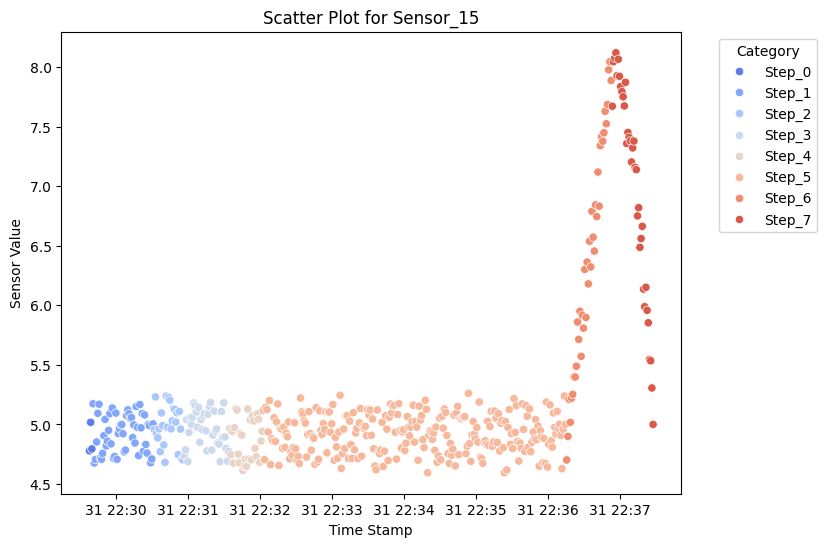

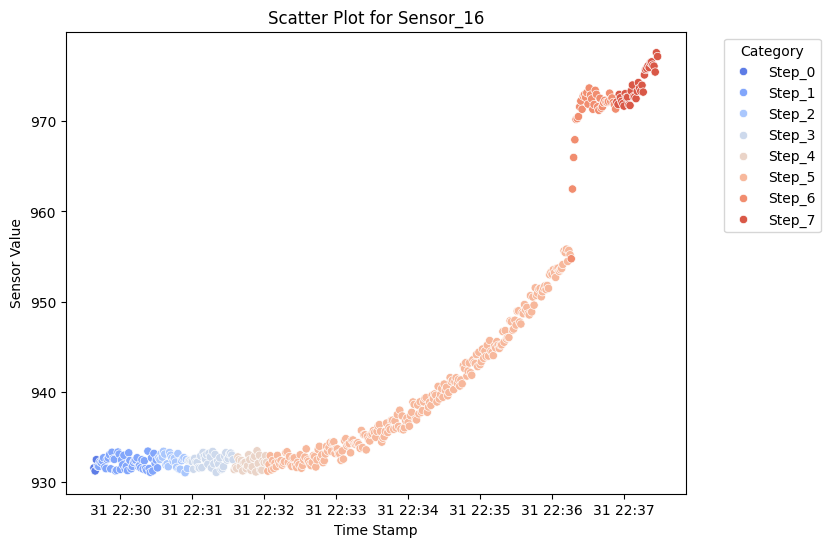

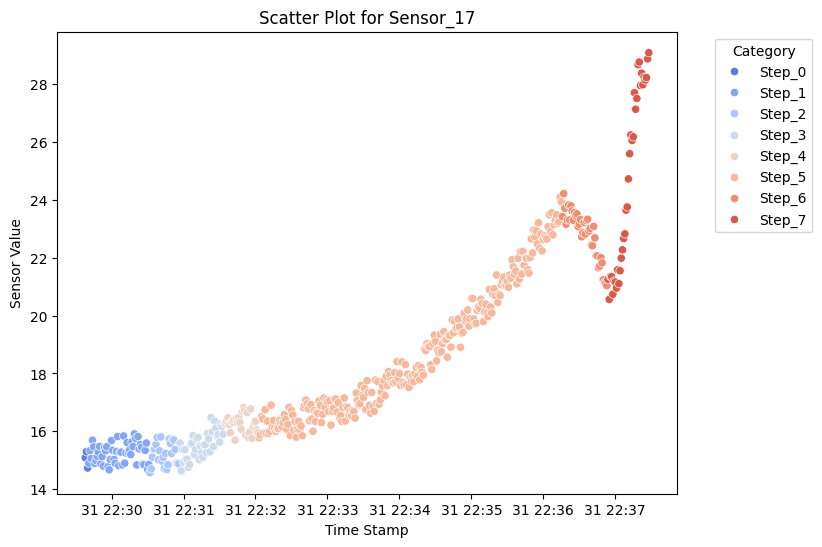

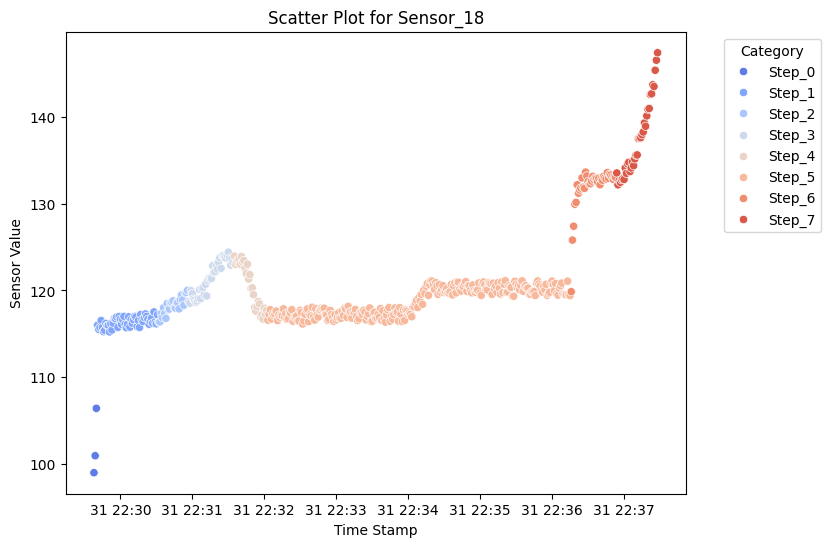

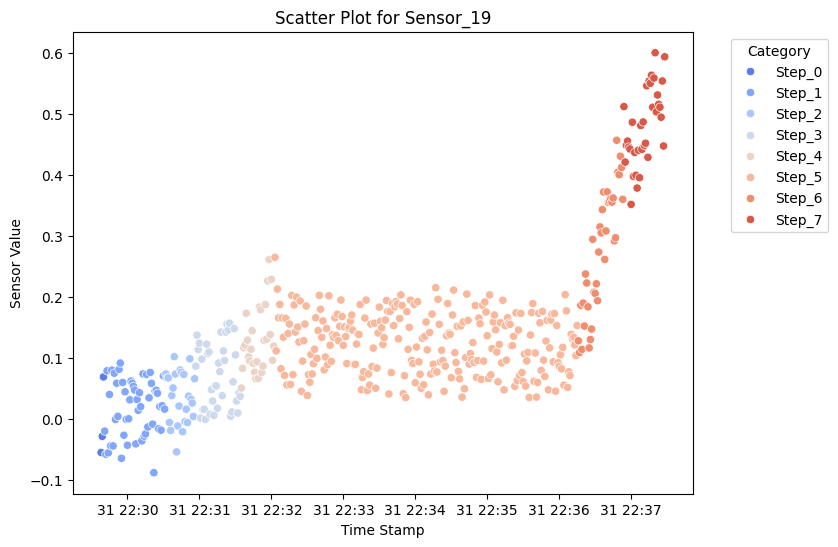

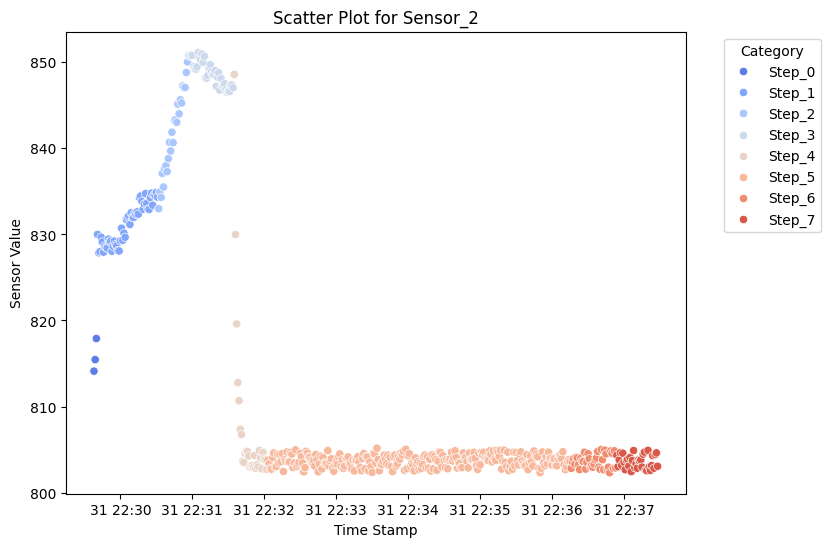

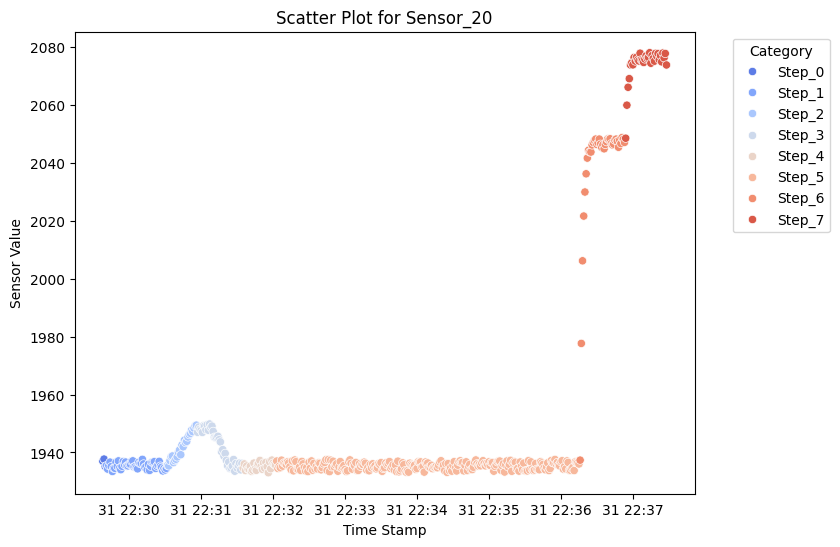

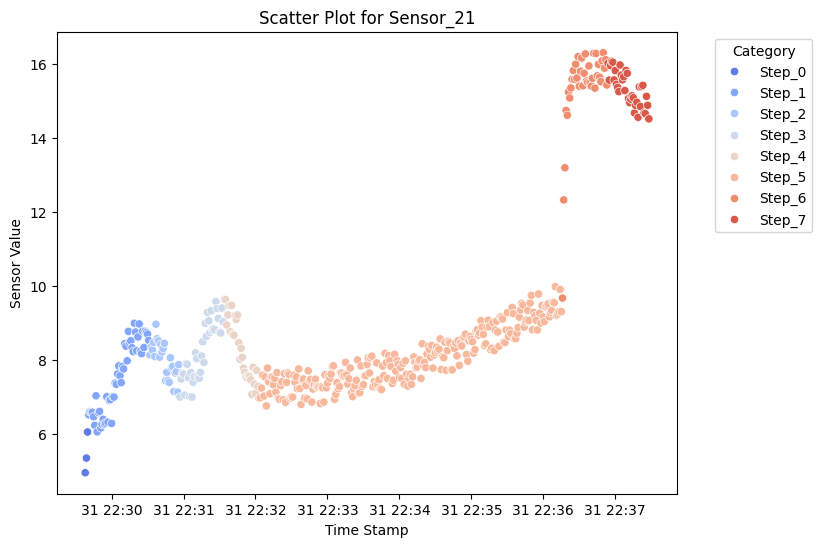

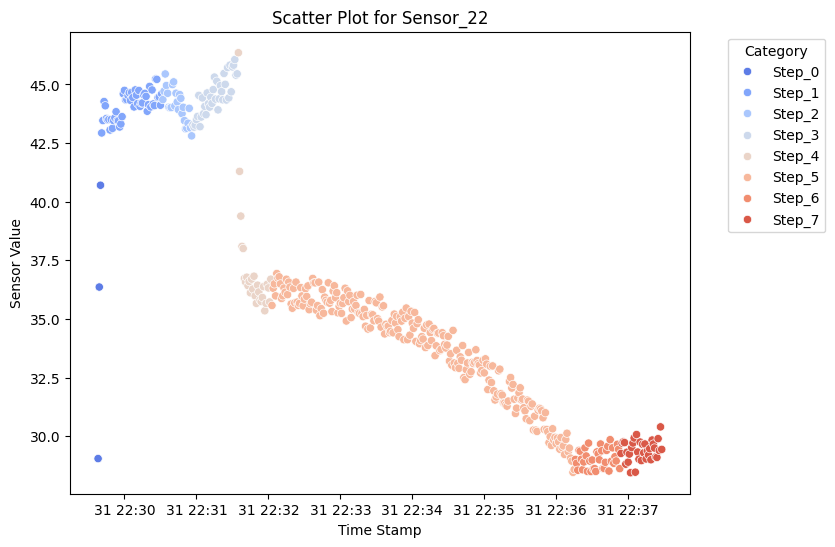

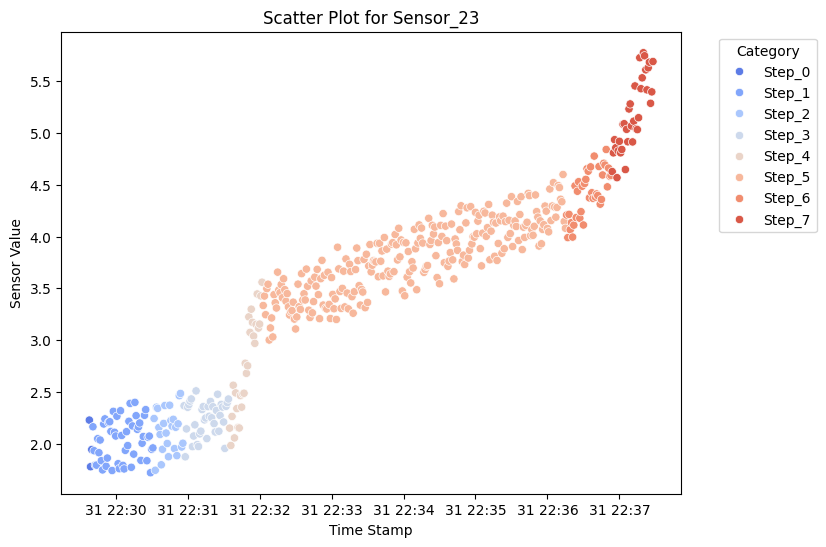

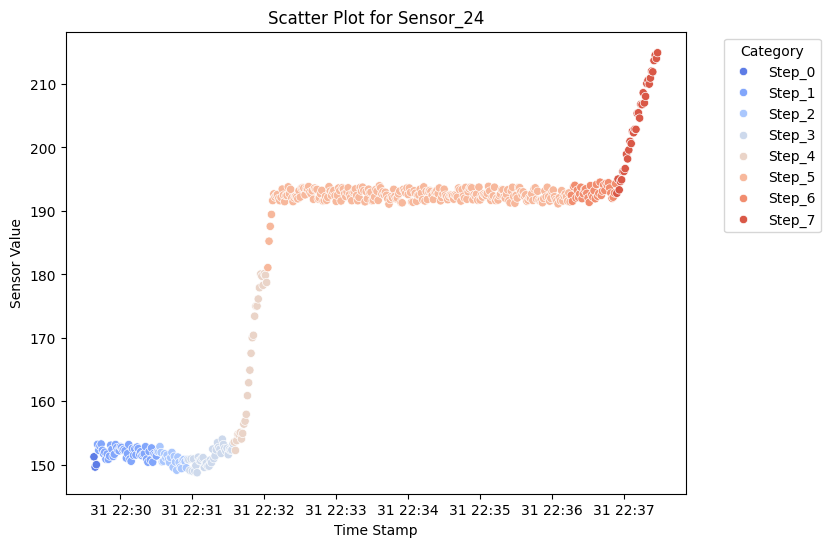

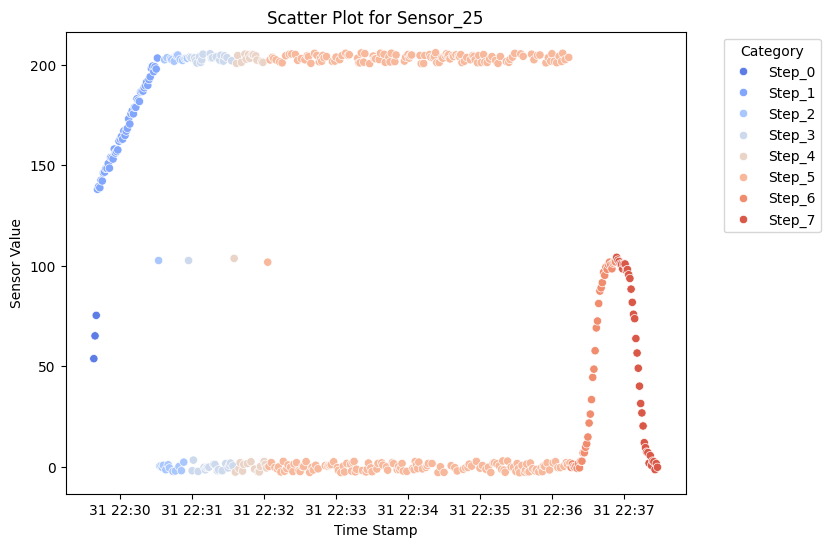

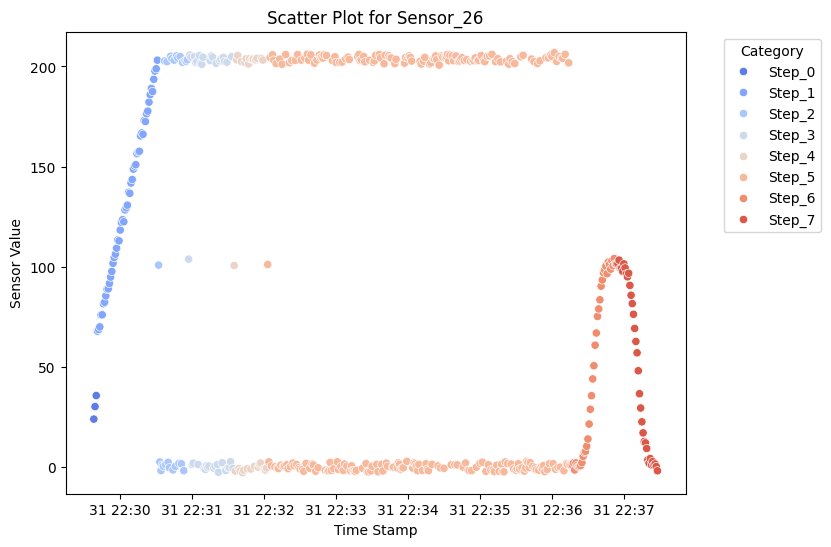

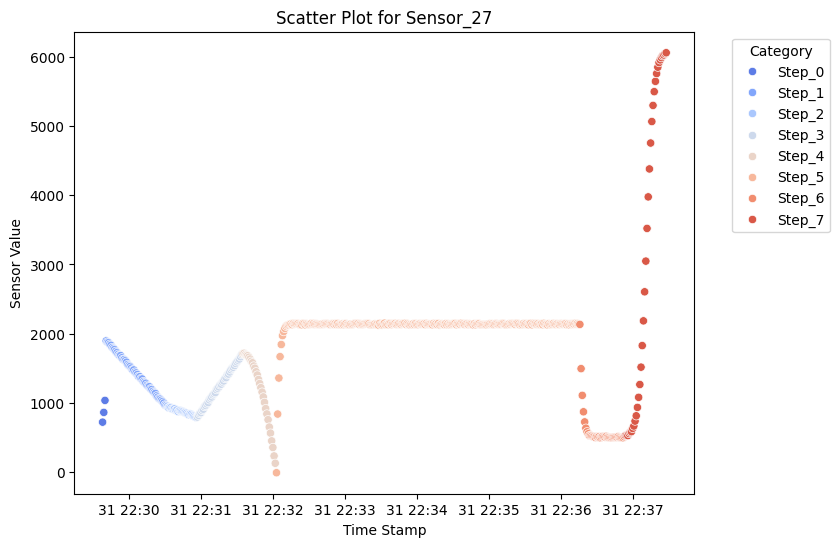

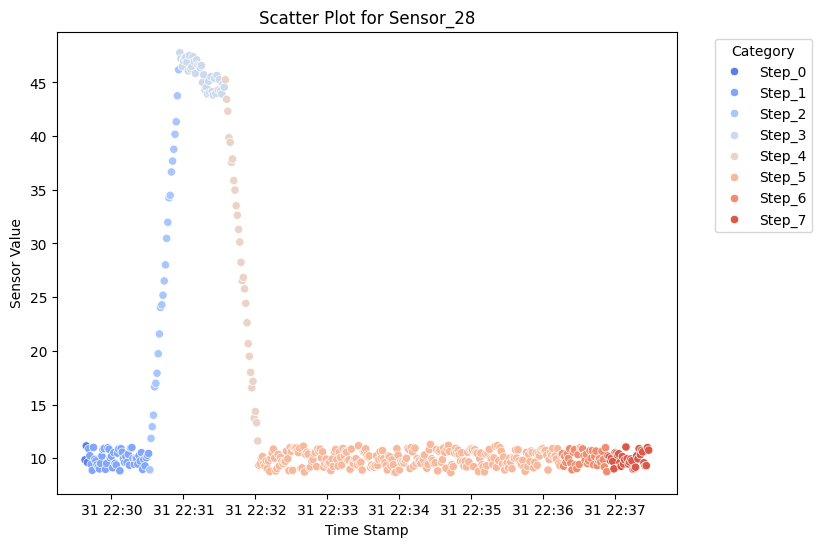

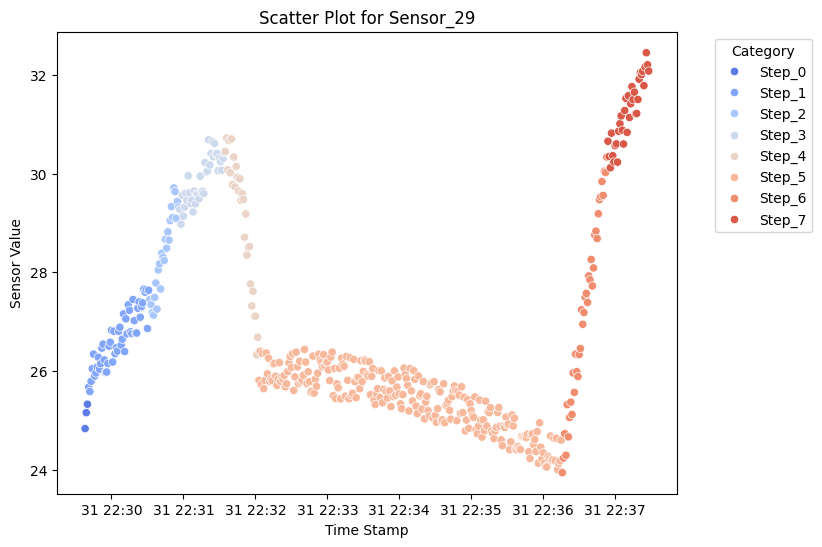

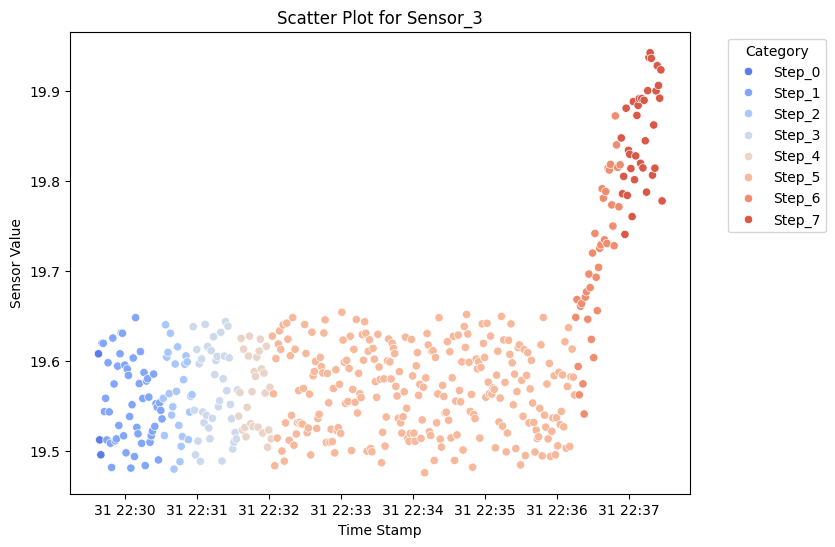

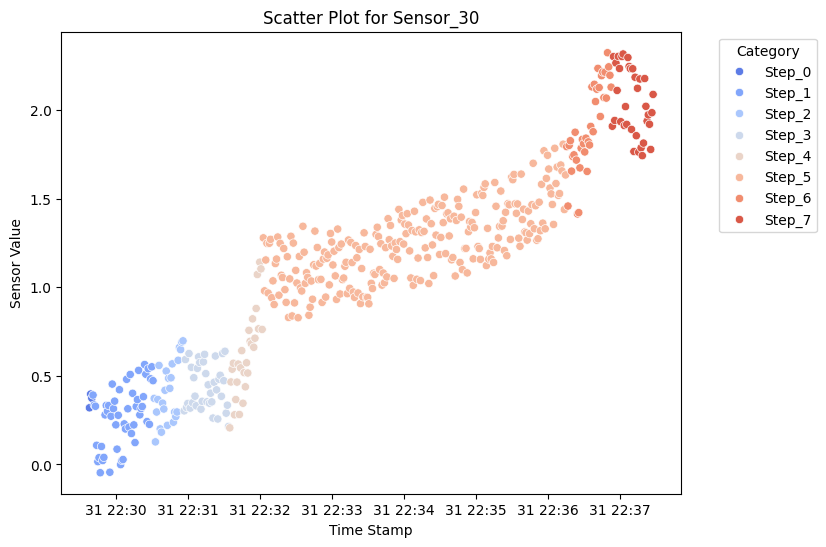

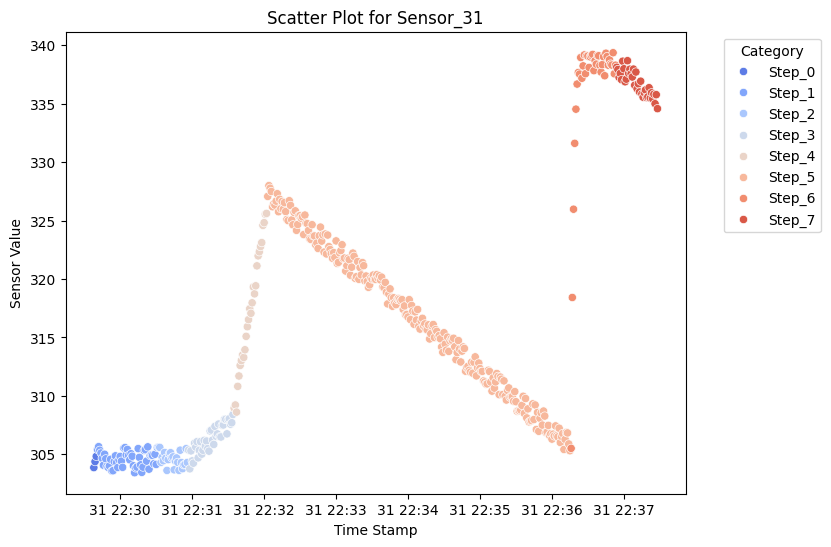

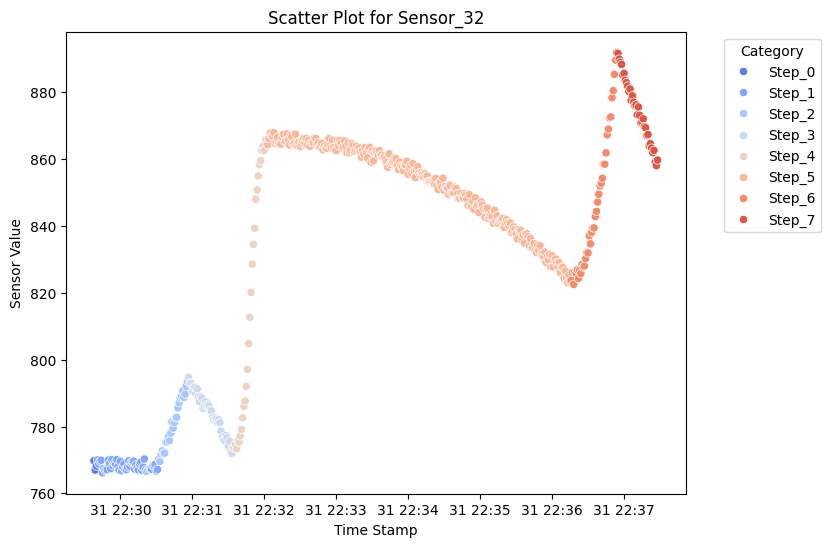

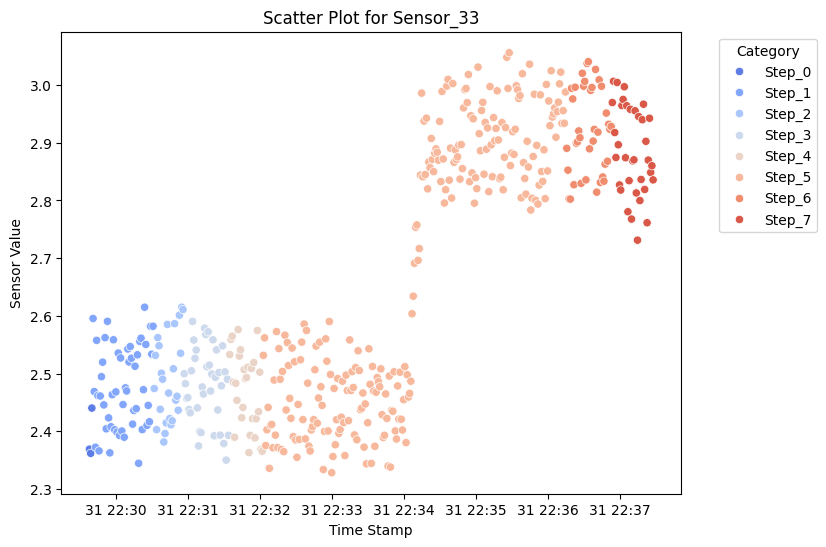

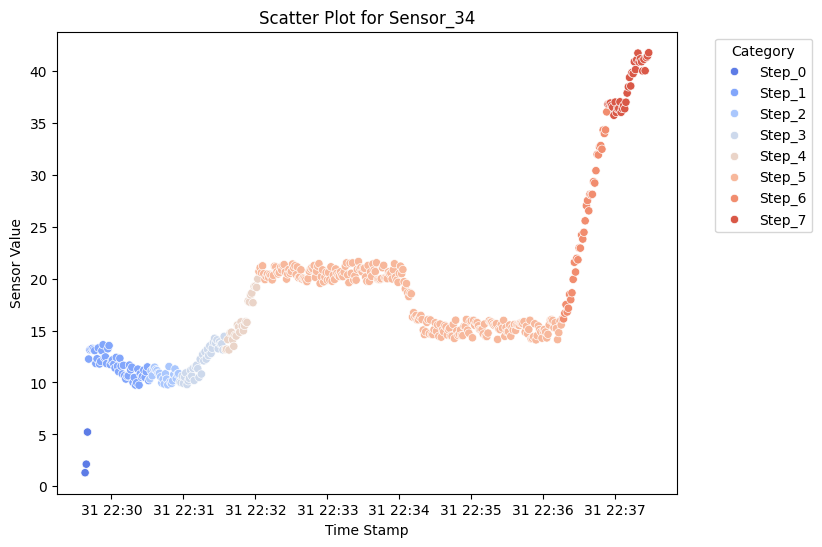

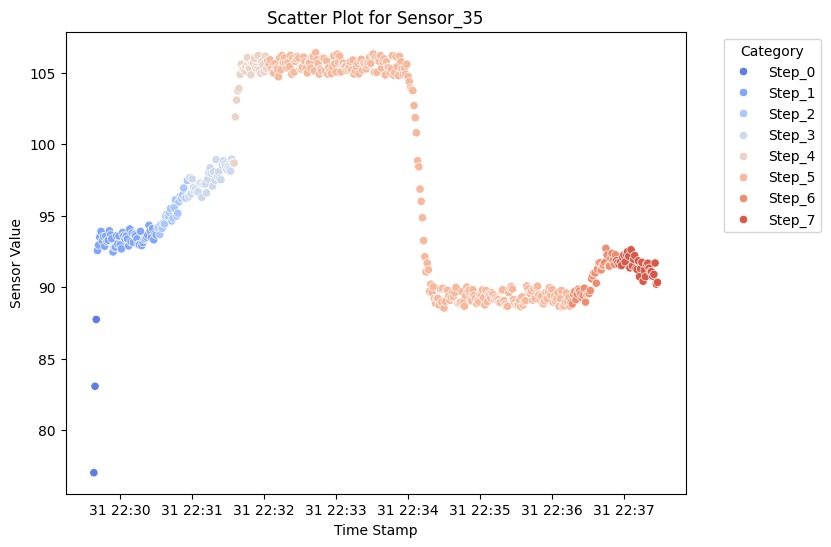

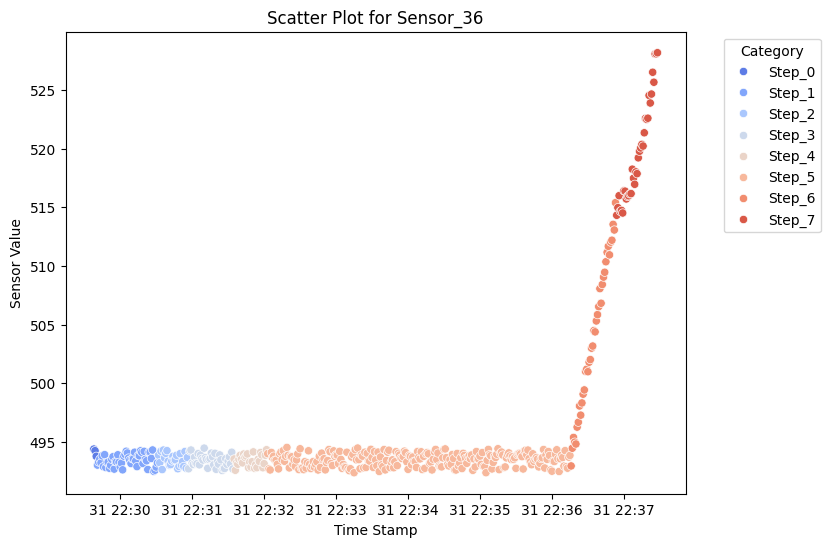

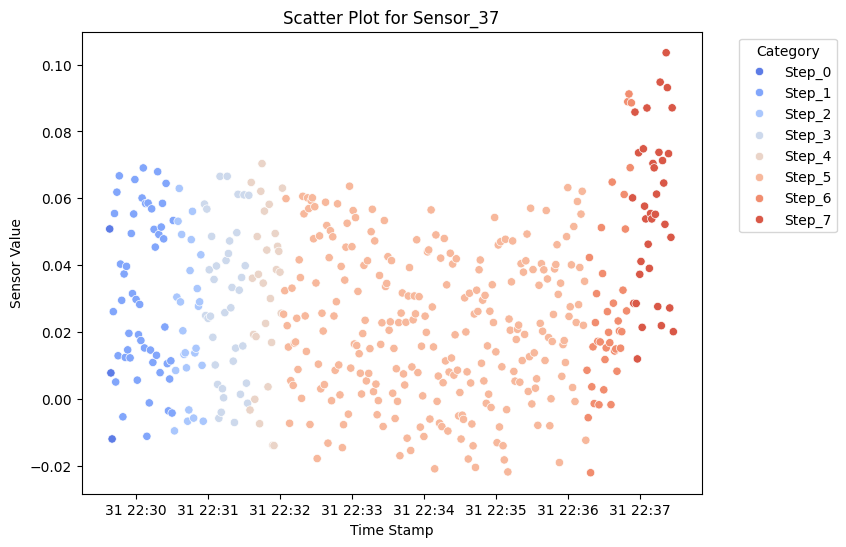

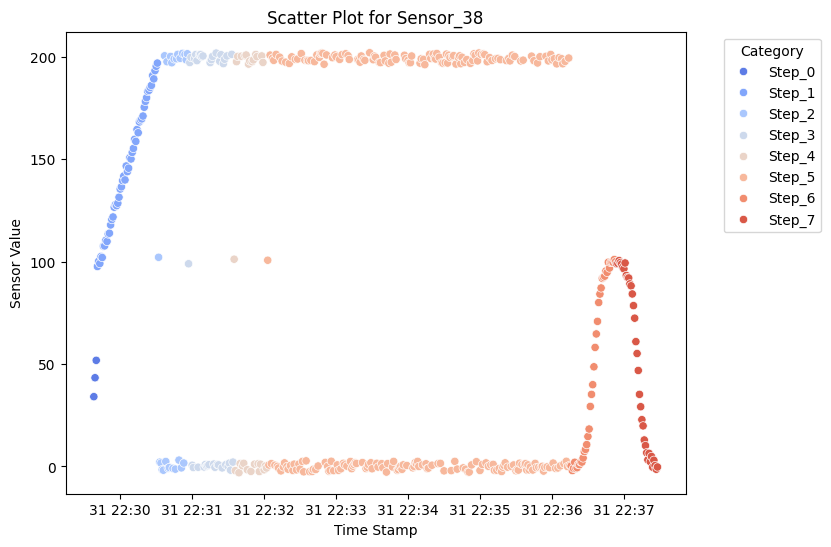

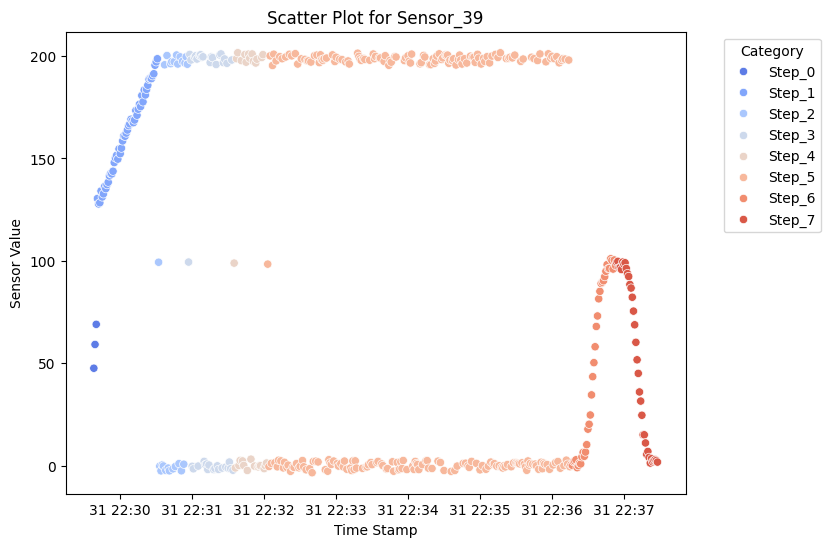

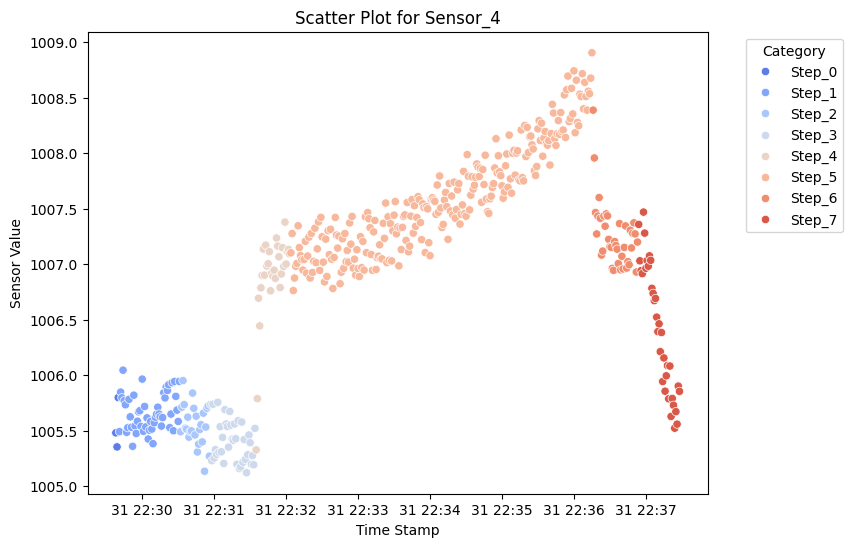

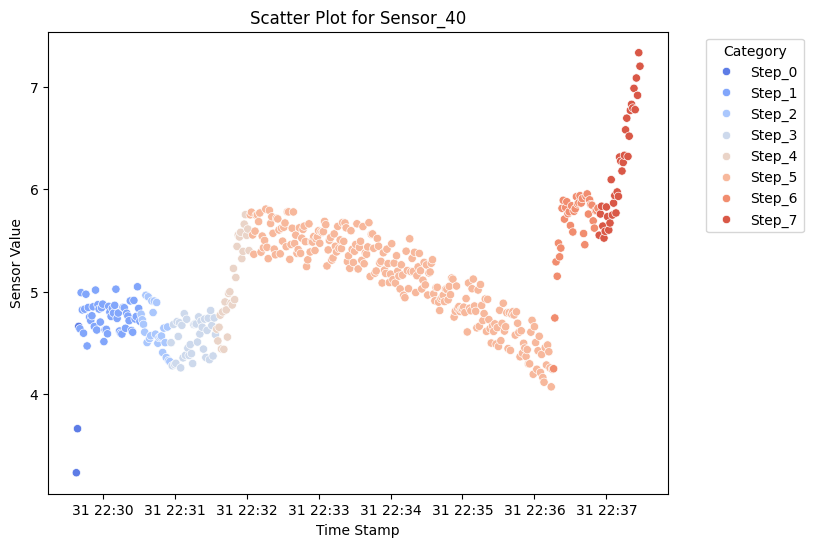

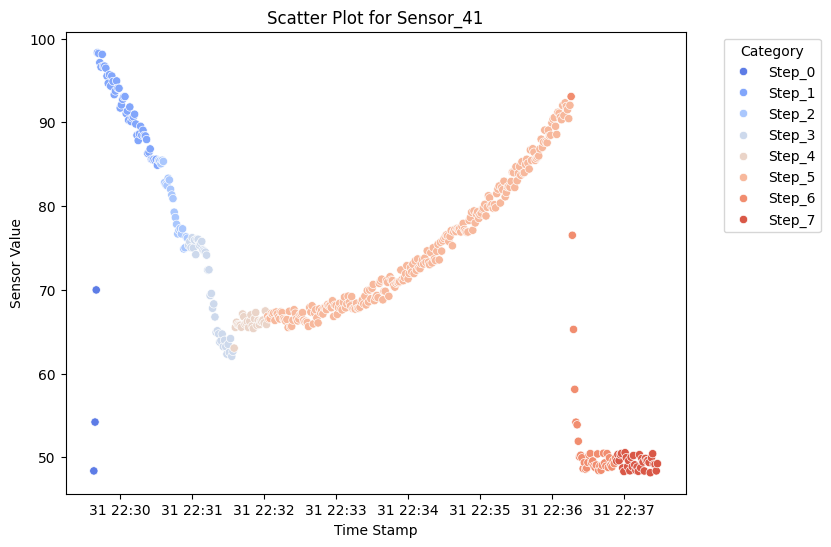

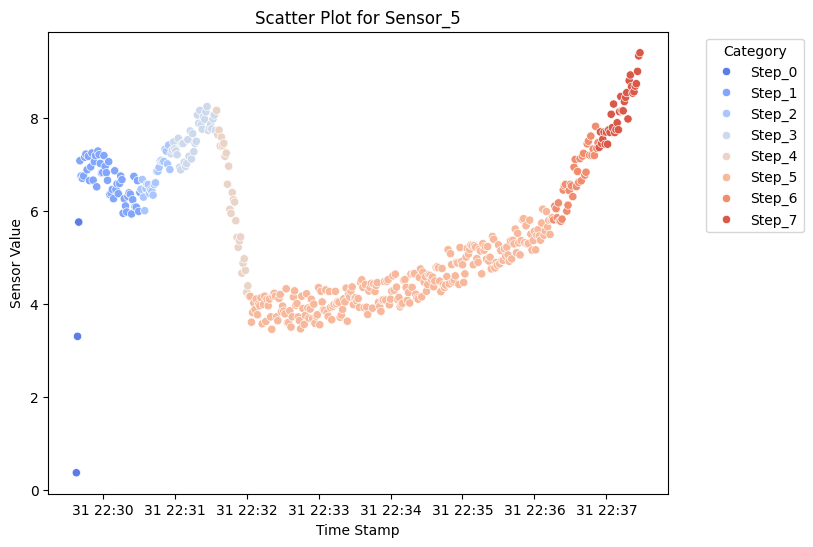

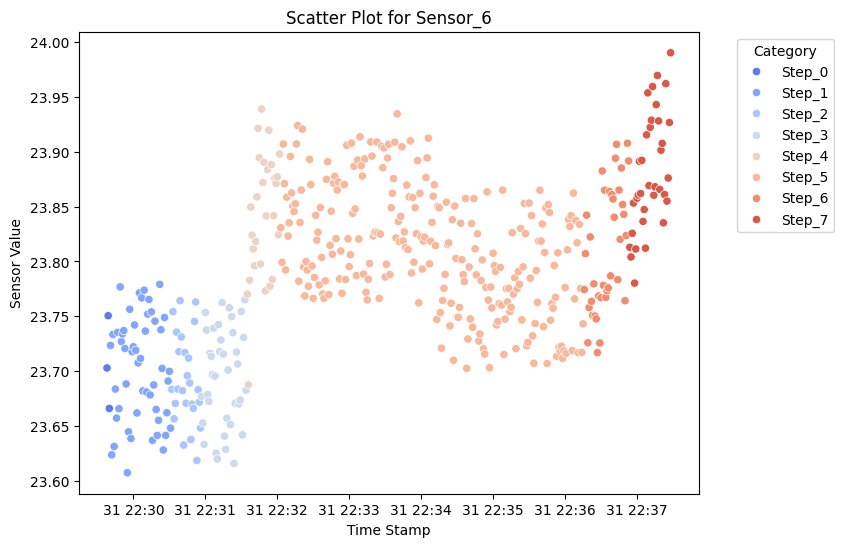

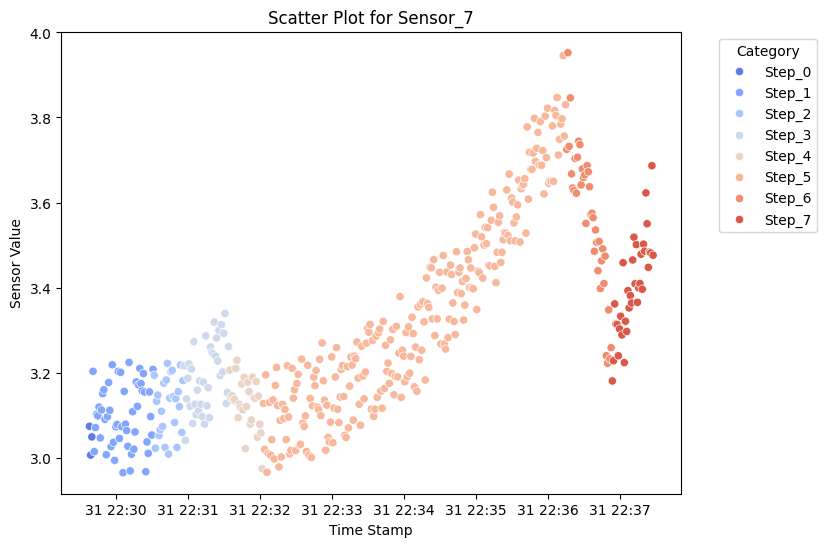

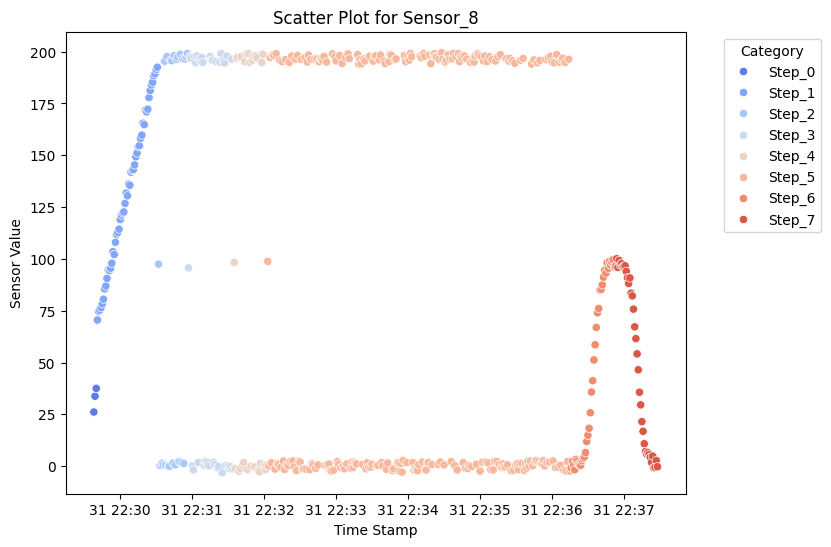

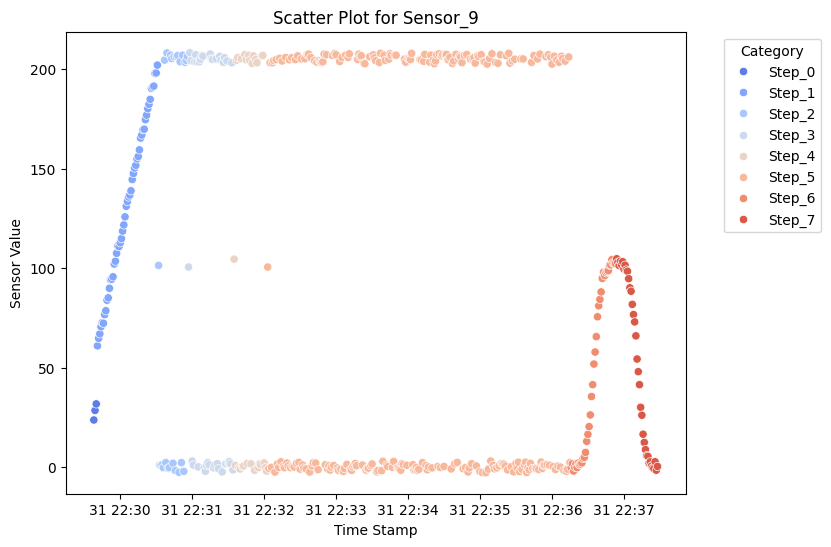

In [40]:
for sensor in filtered_incom_df['Sensor Name'].unique():
    subset_df = filtered_incom_df[filtered_incom_df['Sensor Name'] == sensor]  # Filter data for each Run ID
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='Time Stamp', y='Sensor Value', hue='Step ID', palette='coolwarm', data=subset_df)
    plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f"Scatter Plot for {sensor}")
    plt.show()


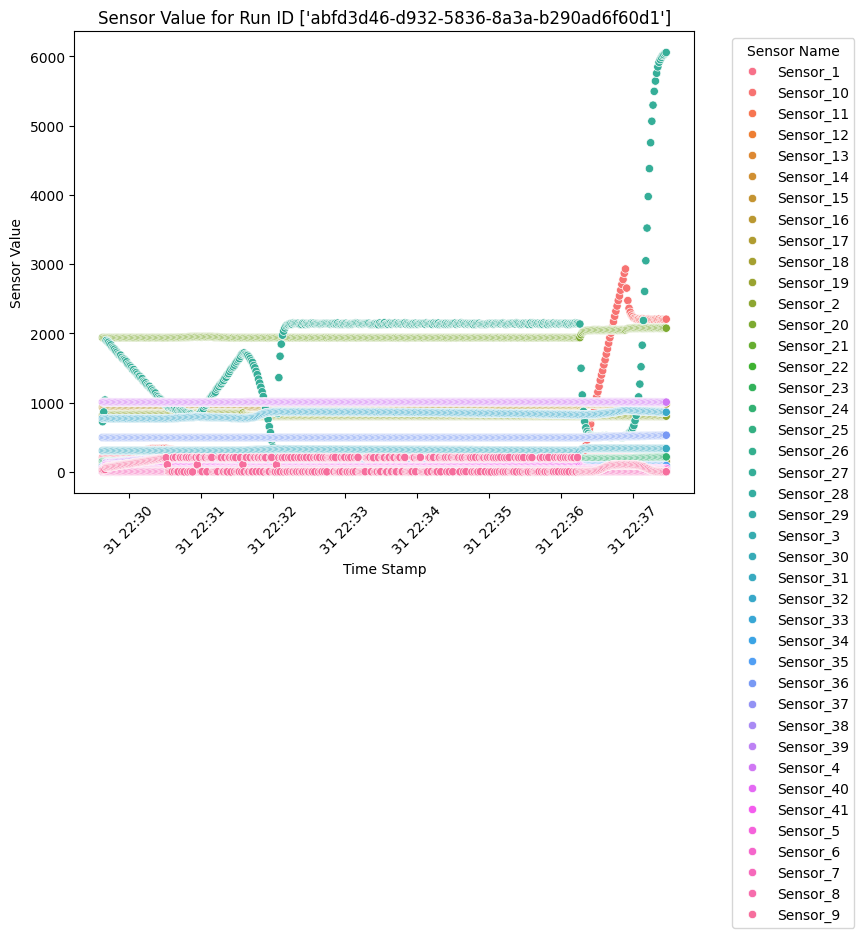

In [41]:
# Plot the graph with categorization
plt.figure(figsize=(8, 6))  # Adjust figure size
sns.scatterplot(x='Time Stamp', y='Sensor Value', hue='Sensor Name', data=filtered_incom_df)

plt.title(f'Sensor Value for Run ID {random_run_ids}')
plt.legend(title="Sensor Name", bbox_to_anchor=(1.05, 1), loc='upper left')  # Ensure legend shows sensor categories
plt.xticks(rotation=45)  # Rotate timestamps for readability

# Show the plot
plt.show()


In [ ]:
filtered_df['Run type'] = 'current_run'
filtered_incom_df['Run type'] = 'incoming_run'

C:\Users\felic\AppData\Local\Temp\ipykernel_7852\508896814.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Run type'] = 'current_run'
C:\Users\felic\AppData\Local\Temp\ipykernel_7852\508896814.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_incom_df['Run type'] = 'incoming_run'


In [61]:
df_combined = pd.concat([filtered_df, filtered_incom_df], ignore_index=True)

In [ ]:
grouped_df = df_combined.groupby(["Sensor Name"])["Sensor Value"].mean()
print(grouped_df.head(100))

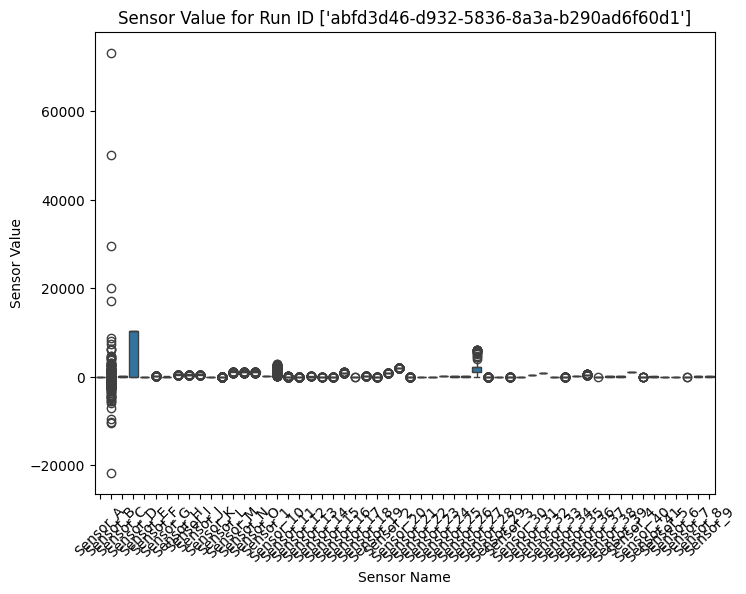

In [50]:
# Plot the graph
plt.figure(figsize=(8, 6))  # Adjust figure size
sns.boxplot(x='Sensor Name', y='Sensor Value', data=df_combined)
plt.xticks(rotation=45)
plt.title(f'Sensor Value for Run ID {random_run_ids}')

# Show the plot
plt.show()

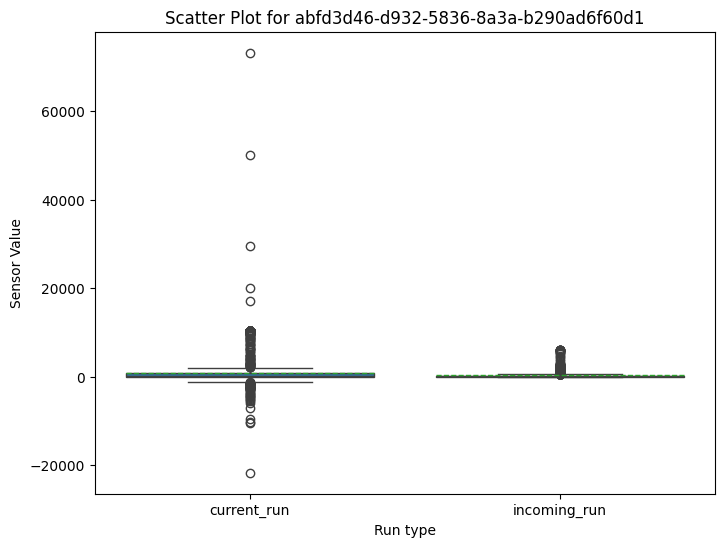

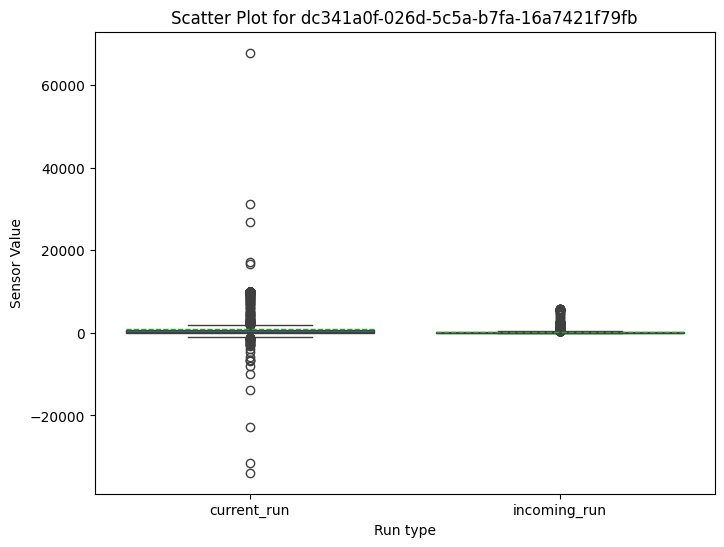

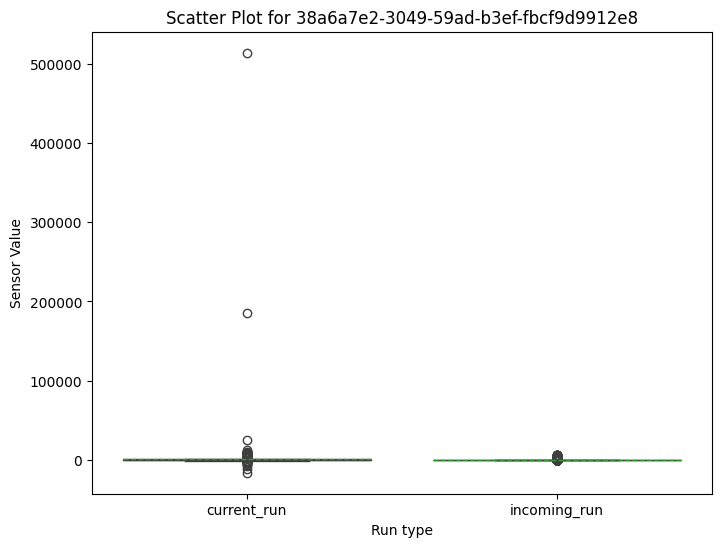

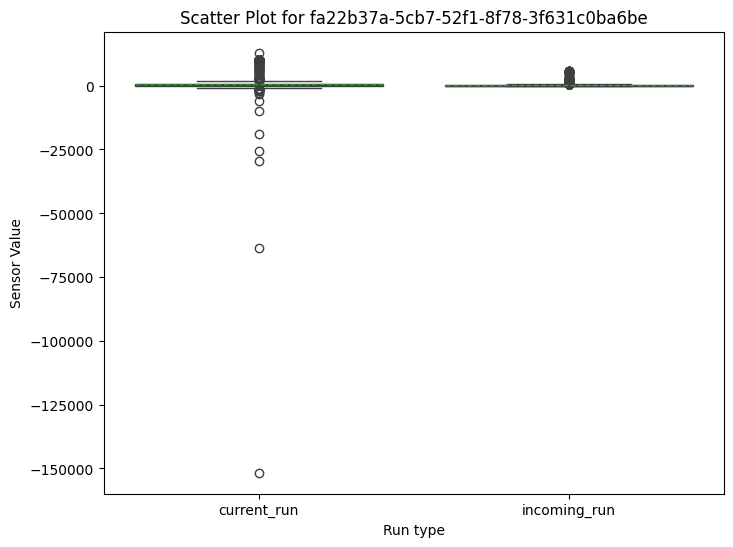

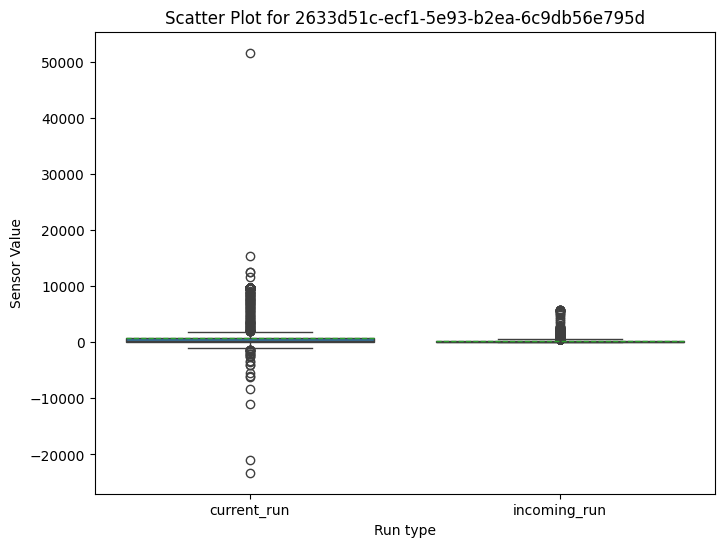

In [75]:
for run in df_combined['Run ID'].unique():
    subset_df = df_combined[df_combined['Run ID'] == run]  # Filter data for each Run ID

    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Run type', y='Sensor Value', data = subset_df, showmeans=True, meanline=True)
    plt.title(f"Scatter Plot for {run}")
    plt.show()


In [85]:
for run in df_combined['Run ID'].unique():
    subset_df = df_combined[df_combined['Run ID'] == run]  # Filter data for each Run ID

    print(f'Stats for run {run}')
    print(subset_df.groupby('Run type')['Sensor Value'].mean())

Stats for run abfd3d46-d932-5836-8a3a-b290ad6f60d1
Run type
current_run     838.765869
incoming_run    244.478073
Name: Sensor Value, dtype: float32
Stats for run dc341a0f-026d-5c5a-b7fa-16a7421f79fb
Run type
current_run     795.540466
incoming_run    242.569183
Name: Sensor Value, dtype: float32
Stats for run 38a6a7e2-3049-59ad-b3ef-fbcf9d9912e8
Run type
current_run     842.156067
incoming_run    246.334259
Name: Sensor Value, dtype: float32
Stats for run fa22b37a-5cb7-52f1-8f78-3f631c0ba6be
Run type
current_run     763.214294
incoming_run    249.410095
Name: Sensor Value, dtype: float32
Stats for run 2633d51c-ecf1-5e93-b2ea-6c9db56e795d
Run type
current_run     765.023315
incoming_run    247.185501
Name: Sensor Value, dtype: float32


In [91]:
from scipy.stats import spearmanr

# Separate values for each category
values_A = df_combined[df_combined['Run type'] == 'current_run']['Sensor Value']
values_B = df_combined[df_combined['Run type'] == 'incoming_run']['Sensor Value']

values_B2 = values_B.sample(len(values_A))

# Compute Spearman correlation
corr, p_value = spearmanr(values_A, values_B2)

print(f"Spearman correlation: {corr}, p-value: {p_value}")

Spearman correlation: -0.006280078530878202, p-value: 0.16668003619992391


In [20]:
meas_df.head()

Run ID      Run Start Time  \
0  00862337-2cc0-5b34-b5e1-45588e935c39 2024-01-02 04:45:25   
1  00862337-2cc0-5b34-b5e1-45588e935c39 2024-01-02 04:45:25   
2  00862337-2cc0-5b34-b5e1-45588e935c39 2024-01-02 04:45:25   
3  00862337-2cc0-5b34-b5e1-45588e935c39 2024-01-02 04:45:25   
4  00862337-2cc0-5b34-b5e1-45588e935c39 2024-01-02 04:45:25   

         Run End Time  X_index  Y_index           X          Y  Point Index  \
0 2024-01-02 04:58:00        1       23 -143.877551  -9.183673            3   
1 2024-01-02 04:58:00        1       29 -143.877551  27.551020           48   
2 2024-01-02 04:58:00        2       34 -137.755102  58.163265           43   
3 2024-01-02 04:58:00        3       14 -131.632653 -64.285714           20   
4 2024-01-02 04:58:00        5       39 -119.387755  88.775510            8   

   Measurement  
0    10.006534  
1    10.002181  
2    10.031223  
3    10.055888  
4    10.089505

In [21]:
print(meas_df.columns.tolist())

['Run ID', 'Run Start Time', 'Run End Time', 'X_index', 'Y_index', 'X', 'Y', 'Point Index', 'Measurement']


In [34]:
# Number of random run IDs you want to select
num_random_ids = 10

# Select random run IDs
random_meas_ids = meas_df['Run ID'].sample(n=num_random_ids, random_state=42).tolist()

print(random_meas_ids)

# Filter the DataFrame
filtered_meas_df = meas_df[meas_df['Run ID'].isin(random_meas_ids)]

['942d7cbe-c605-5fd5-bd56-c0eea717e7ba', '0fc37256-b164-556d-afac-991af03d3597', '5b5d84ba-ad8c-5710-a6a5-c1a1184a55d2', 'abfd3d46-d932-5836-8a3a-b290ad6f60d1', 'e5e893e4-84ae-50d8-82c7-48d4035d59ea', '45a1737c-84a3-5322-b70e-471b0695cc0f', 'd16f9db5-bd07-5554-adee-e2196fd1d84b', '98416cf0-5695-5229-a779-ecfc92227346', 'd8818043-14e1-54b7-960f-a480665be44a', '01e7fa15-f005-55f9-986c-9dc47fee5114']


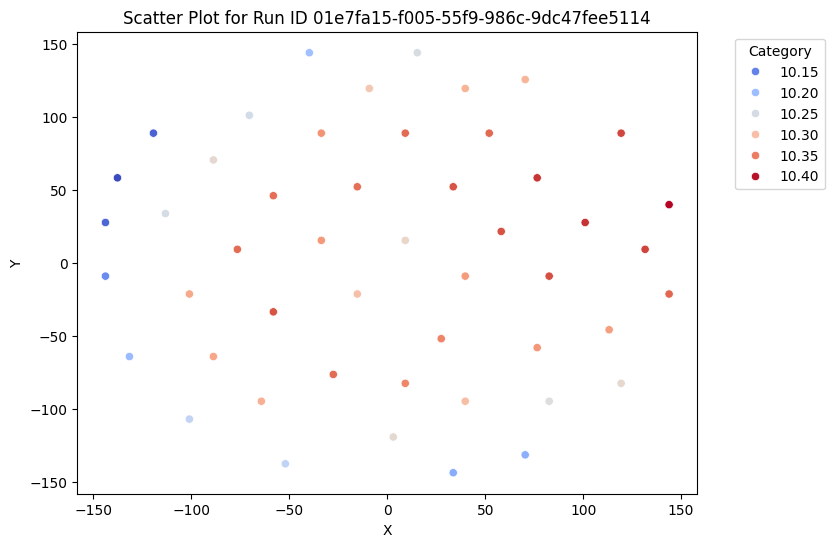

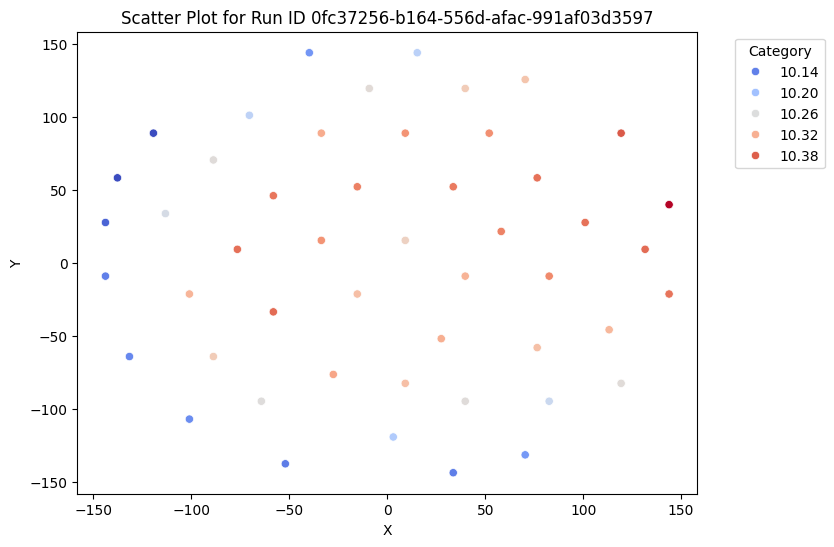

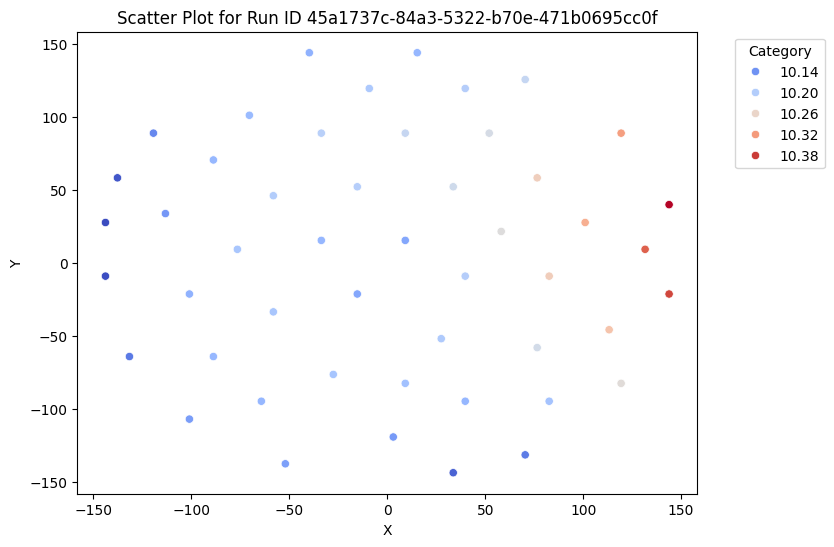

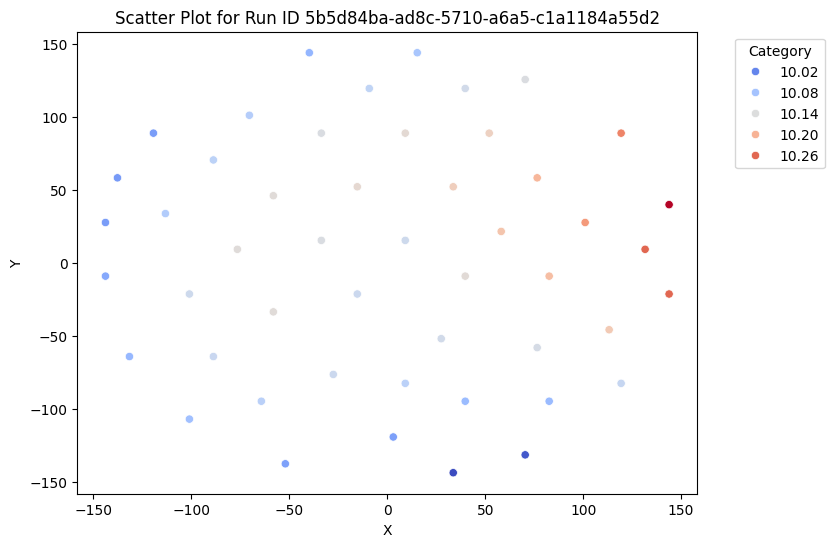

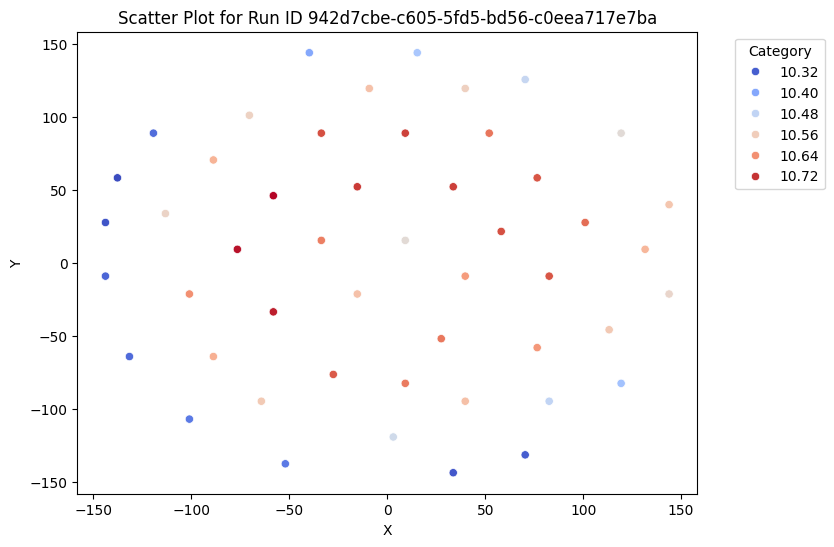

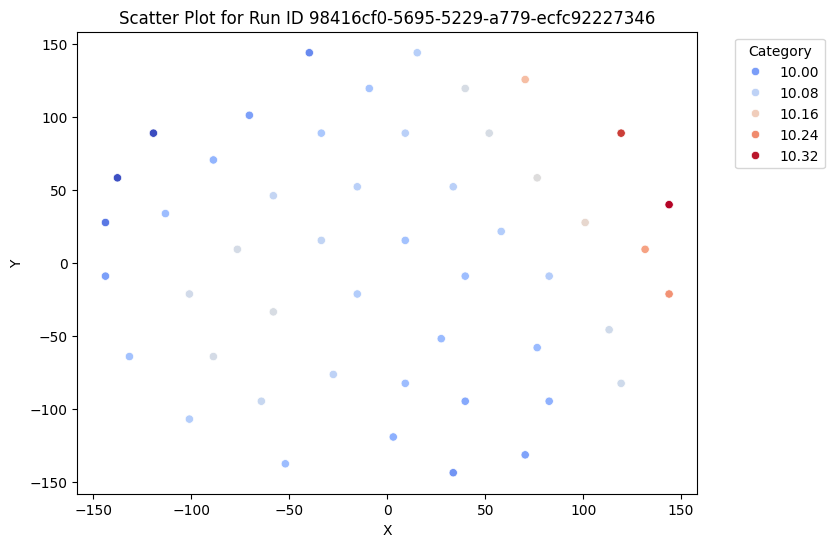

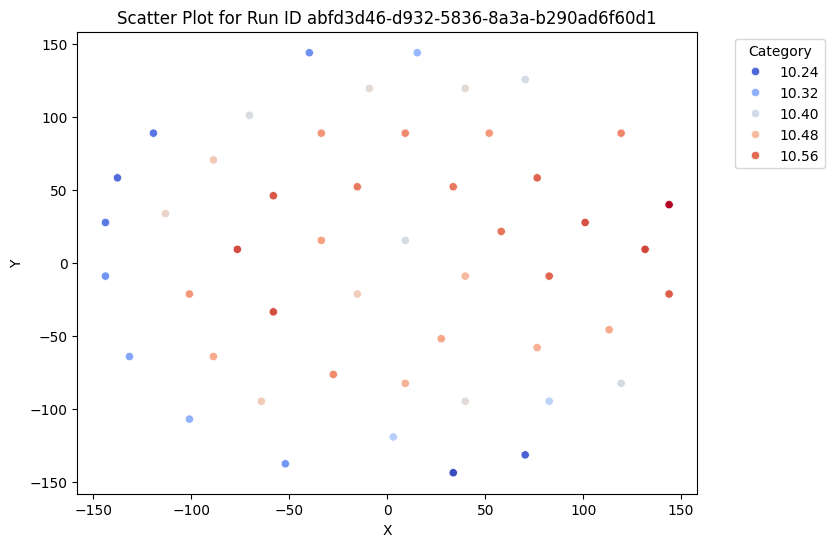

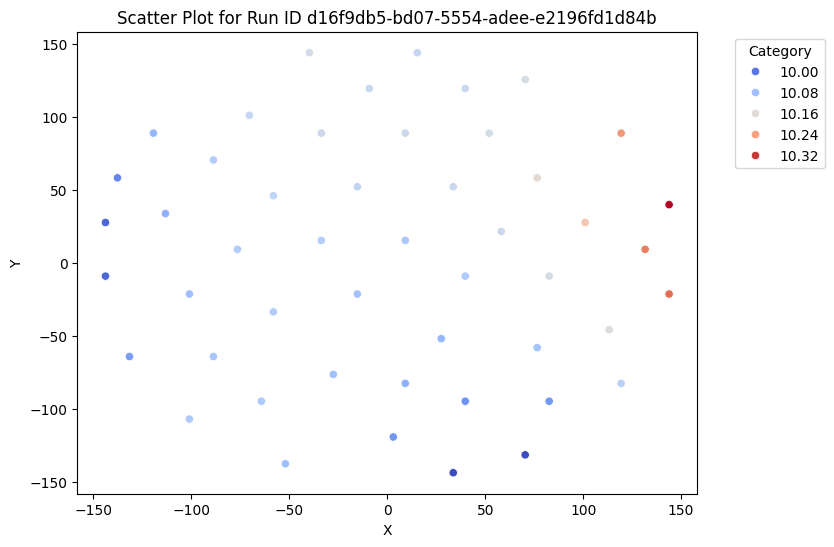

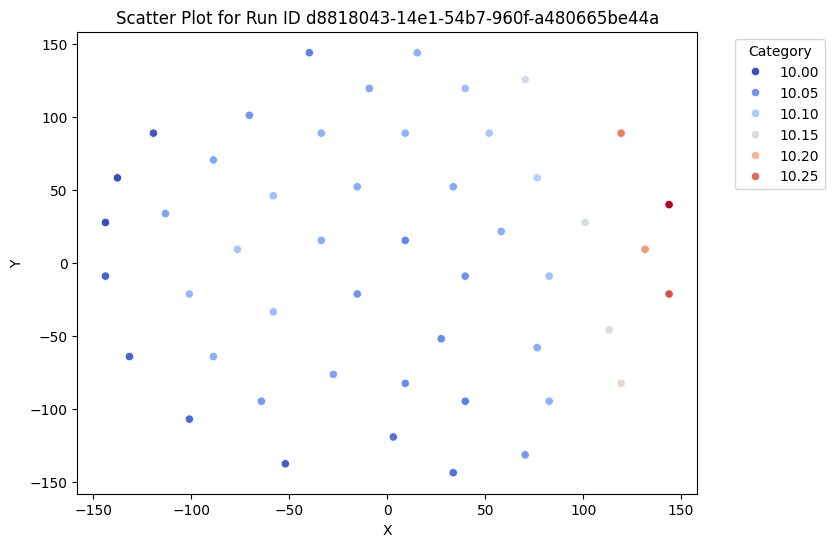

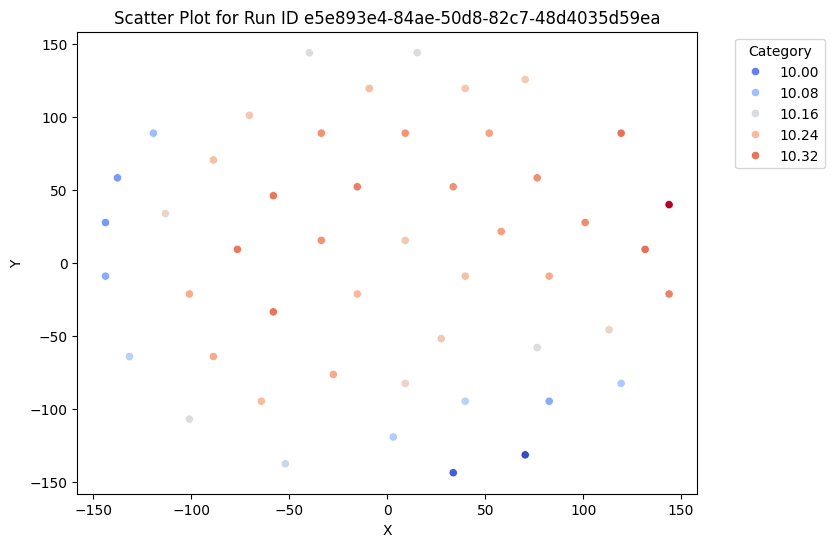

In [60]:
# Loop through each unique Run ID and create a separate plot
for run_id in filtered_meas_df['Run ID'].unique():
    subset_df = meas_df[meas_df['Run ID'] == run_id]  # Filter data for each Run ID
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='X', y='Y', hue='Measurement', palette='coolwarm', data=subset_df)
    # sns.kdeplot(x='X', y='Y', weights='Measurement', cmap='coolwarm', fill = True, data = subset_df)
    # sns.scatterplot(x='X', y='Y', size='Measurement', sizes=(10, 200), data=subset_df)
    plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f"Scatter Plot for Run ID {run_id}")
    plt.show()


In [ ]:
# 2b. Tool-life feature: max ConsumableLife per run
life_feat = (
    run_df
      .groupby("Run ID")["Consumable Life"]
      .max()
      .rename("ConsumableLifeMax")
      .reset_index()
)

# merge features
meas_combined = meas_df.merge(life_feat, on="Run ID")

In [62]:
print(meas_combined.head())

                                 Run ID      Run Start Time  \
0  00862337-2cc0-5b34-b5e1-45588e935c39 2024-01-02 04:45:25   
1  00862337-2cc0-5b34-b5e1-45588e935c39 2024-01-02 04:45:25   
2  00862337-2cc0-5b34-b5e1-45588e935c39 2024-01-02 04:45:25   
3  00862337-2cc0-5b34-b5e1-45588e935c39 2024-01-02 04:45:25   
4  00862337-2cc0-5b34-b5e1-45588e935c39 2024-01-02 04:45:25   

         Run End Time  X_index  Y_index           X          Y  Point Index  \
0 2024-01-02 04:58:00        1       23 -143.877551  -9.183673            3   
1 2024-01-02 04:58:00        1       29 -143.877551  27.551020           48   
2 2024-01-02 04:58:00        2       34 -137.755102  58.163265           43   
3 2024-01-02 04:58:00        3       14 -131.632653 -64.285714           20   
4 2024-01-02 04:58:00        5       39 -119.387755  88.775510            8   

   Measurement  ConsumableLifeMax  
0    10.006534          34.683315  
1    10.002181          34.683315  
2    10.031223          34.683315  
3 

In [91]:
# Number of random measurements you want to select
num_random_ids = 10

# Select random run IDs
random_point_ids = meas_combined['Point Index'].sample(n=num_random_ids, random_state=42).tolist()
print(random_point_ids)

# Filter the DataFrame
filtered_point_df = meas_combined[meas_combined['Point Index'].isin(random_point_ids)]

[31, 32, 14, 29, 44, 4, 14, 26, 34, 44]


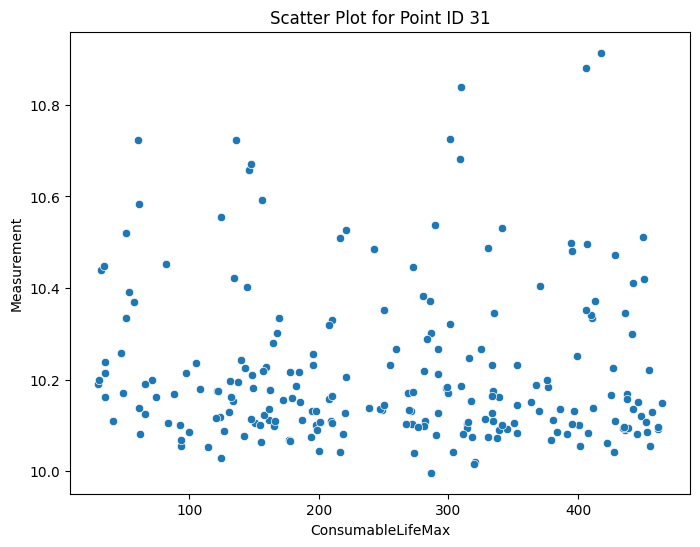

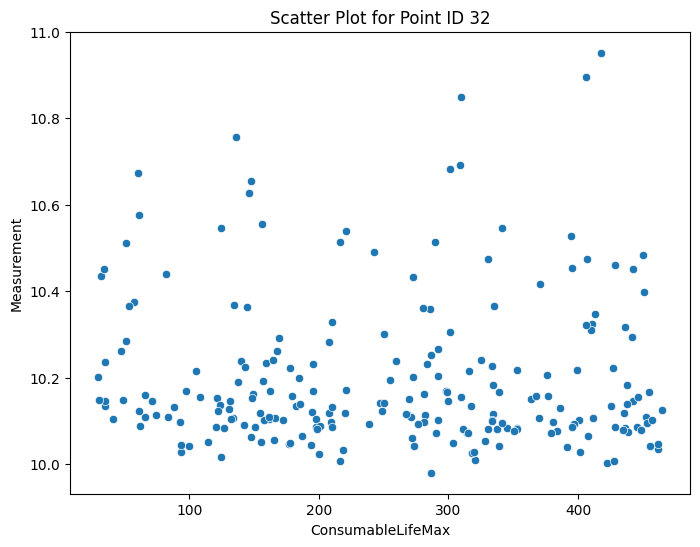

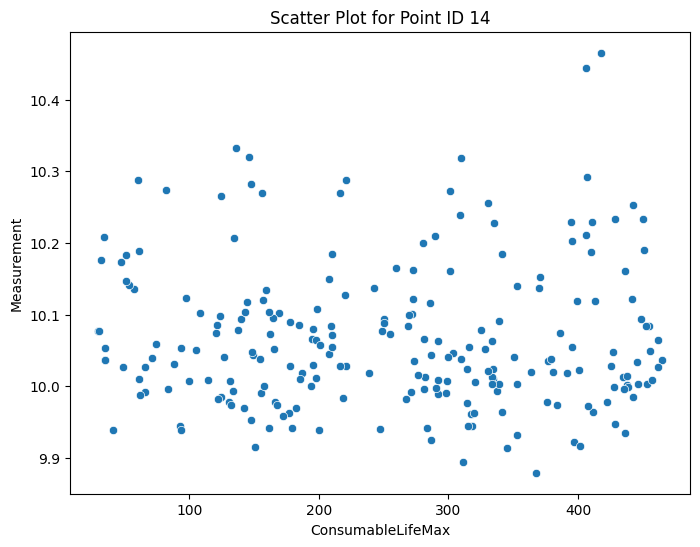

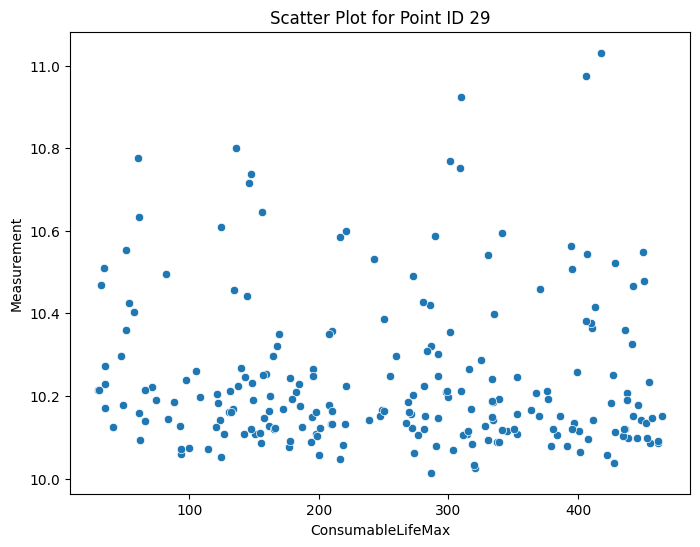

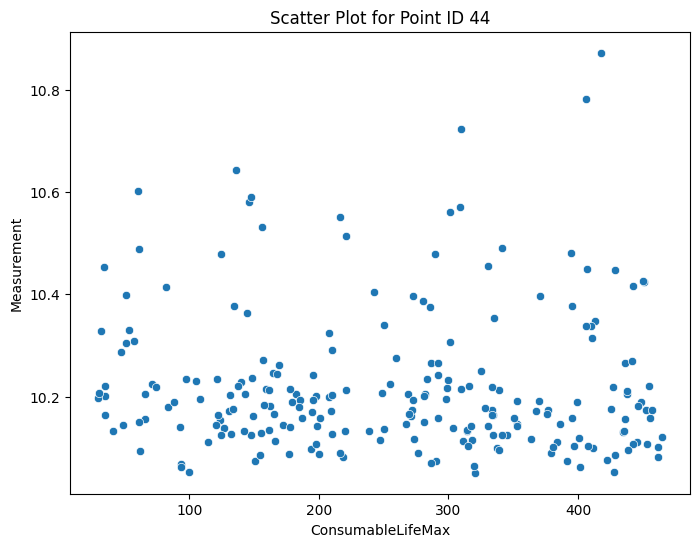

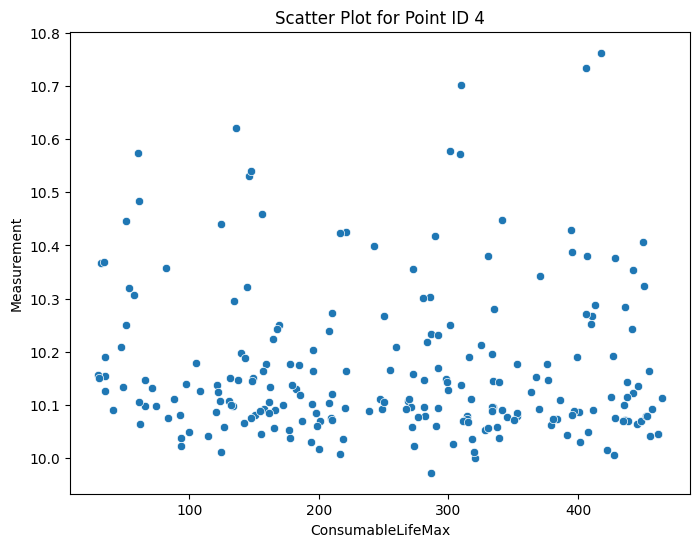

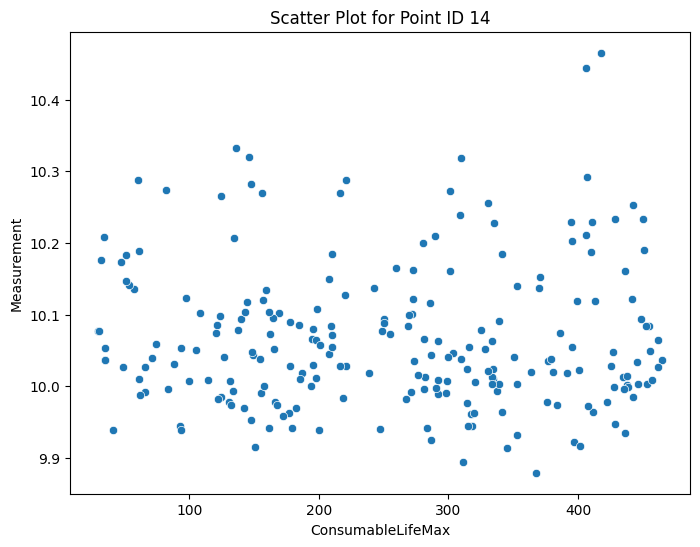

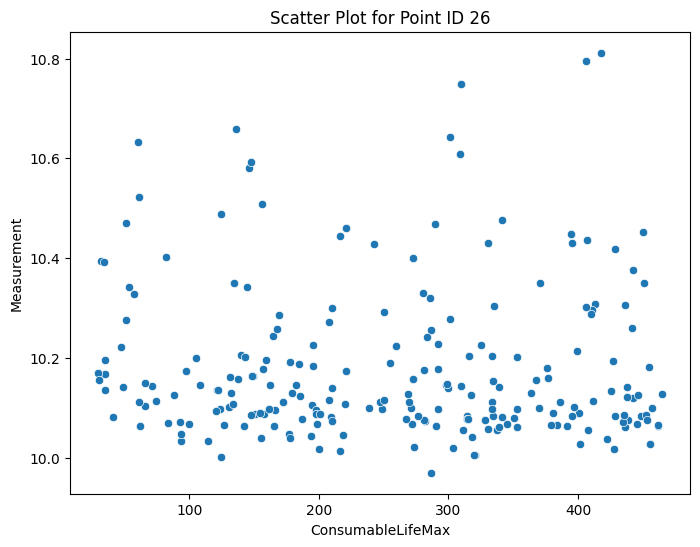

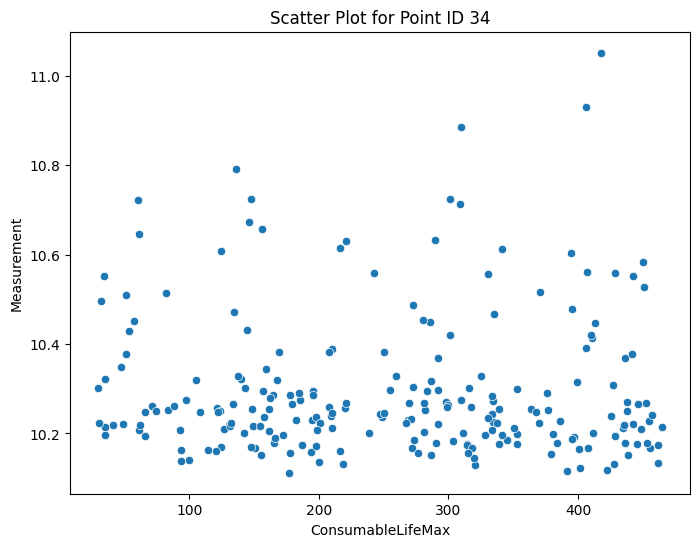

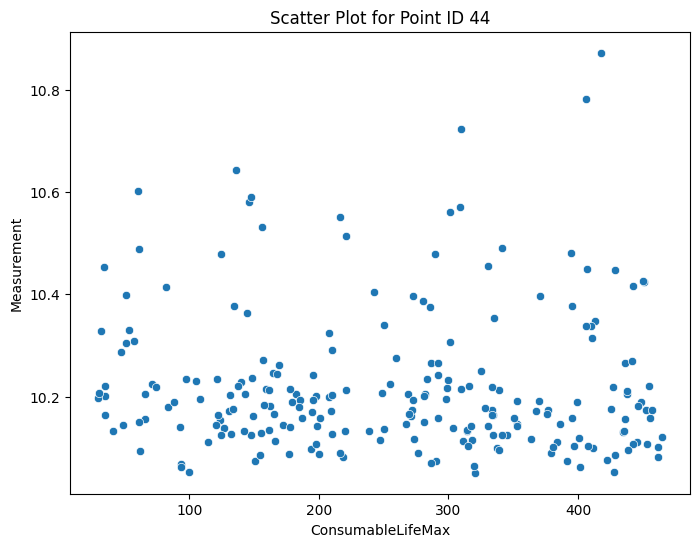

In [98]:
# # Plot the graph
# plt.figure(figsize=(8, 6))  # Adjust figure size
# sns.scatterplot(x='ConsumableLifeMax', y='Measurement', hue='Point Index', data=filtered_point_df)
# plt.xticks(rotation=45)
# plt.title(f'Measurement vs consumable life for Point {random_point_ids}')

# # Show the plot
# plt.show()

# Loop through each unique point
for id in random_point_ids:
    subset_df = filtered_point_df[filtered_point_df['Point Index'] == id]  # Filter data for each Run ID
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='ConsumableLifeMax', y='Measurement', data=subset_df)
    plt.title(f"Scatter Plot for Point ID {id}")
    plt.show()



In [106]:
    # corr_matrix = subset_df.corr(numeric_only=True)["Measurement"].sort_values(ascending=False)
    # print(corr_matrix)

correlations = meas_combined.groupby('Point Index')['ConsumableLifeMax'].corr(meas_combined["Measurement"])

print(correlations)

Point Index
0    -0.009055
1    -0.040203
2    -0.020581
3     0.007541
4    -0.037709
5    -0.023502
6    -0.035239
7     0.043954
8    -0.022710
9    -0.036384
10   -0.022608
11   -0.046031
12   -0.037902
13   -0.028138
14   -0.017190
15   -0.025533
16   -0.023285
17    0.036373
18   -0.037930
19   -0.033956
20    0.029351
21   -0.026178
22   -0.027304
23   -0.041361
24   -0.021352
25   -0.029871
26   -0.038781
27   -0.019477
28   -0.034217
29   -0.043743
30   -0.017456
31   -0.045637
32   -0.030064
33   -0.030192
34   -0.020666
35   -0.042461
36   -0.043892
37   -0.001107
38   -0.008150
39   -0.019050
40   -0.018110
41   -0.042124
42   -0.027298
43   -0.012190
44   -0.040672
45   -0.024593
46   -0.016709
47   -0.034324
48   -0.003605
Name: ConsumableLifeMax, dtype: float64
